In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

sns.set_style("white")

import string
import matplotlib.ticker
import matplotlib.transforms as mtransforms
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches

from typing import Tuple
import anndata
from malid import config, io, helpers, logger
from malid.datamodels import (
    GeneLocus,
    TargetObsColumnEnum,
    map_cross_validation_split_strategy_to_default_target_obs_column,
    healthy_label,
)
from malid.trained_model_wrappers import ConvergentClusterClassifier
import genetools
from statannotations.Annotator import Annotator
import sklearn.metrics
import scipy.stats
from IPython.display import display, Markdown
from slugify import slugify
from tqdm import tqdm

from malid.trained_model_wrappers import (
    VGeneIsotypeSpecificSequenceClassifier,
    VJGeneSpecificSequenceModelRollupClassifier,
)

pd.set_option("display.max_columns", None)

Evaluate model 2 and 3 predictions for known binders vs healthy donor-originating sequences.

Model 2 predictions are calculated as proximity to nearest Covid (or other disease) associated cluster chosen by convergent cluster model.

For BCR, we assume all known binders are IgG, and compare to healthy donor IgG only.

Notice that we pass all known binder database entries through our model. Not just "matches" according to some threshold. (Previously, known binder discovery relied on matching our sequences to known binder DBs with fixed thresholds that we chose by hand. Instead, we now run all known binder DB entries through our model wholesale, and compare to the model outputs we get for healthy donor sequences.)

In [2]:
# We only support split strategies with default target obs column == TargetObsColumnEnum.disease
assert (
    map_cross_validation_split_strategy_to_default_target_obs_column[
        config.cross_validation_split_strategy
    ]
    == TargetObsColumnEnum.disease
)

In [3]:
def extract_disease_cluster_list(clf: ConvergentClusterClassifier, disease: str):
    # Get all clusters
    model2_cluster_class_associations = (
        clf.cluster_centroids_with_class_specific_p_values
    )

    # Melt to columns = [cluster_dominant_label, p_value], but first move consensus_sequence into the set of index columns
    # TODO(refactor): this reset_index().set_index() operation is quite slow
    model2_cluster_class_associations = (
        model2_cluster_class_associations.reset_index()
        .set_index(
            list(model2_cluster_class_associations.index.names) + ["consensus_sequence"]
        )
        .melt(
            # preserve index
            ignore_index=False,
            var_name="cluster_dominant_label",
            value_name="p_value",
        )
    )

    # Filter to clusters associated with each class
    model2_cluster_class_associations = model2_cluster_class_associations[
        model2_cluster_class_associations["p_value"] <= clf.p_value_threshold
    ]

    # Filter to Covid predictive cluster centroids only
    disease_clusters_from_model2 = model2_cluster_class_associations[
        model2_cluster_class_associations["cluster_dominant_label"] == disease
    ]

    return disease_clusters_from_model2

In [4]:
def score_sequences(adata, disease_clusters_from_model2, gene_locus):
    # Assign each test sequence to known cluster with nearest centroid, if possible
    df = ConvergentClusterClassifier._assign_sequences_to_known_clusters(
        df=adata.obs,
        cluster_centroids_by_supergroup=ConvergentClusterClassifier._wrap_cluster_centroids_as_dict_by_supergroup(
            disease_clusters_from_model2
        ),
        sequence_identity_threshold=config.sequence_identity_thresholds.assign_test_sequences_to_clusters[
            gene_locus
        ],
        validate_same_fold_id_and_label=False,
    )

    # Compute (1 - normalized Hamming distance) to get a proximity score.
    # Set to 0 if there were no centroids that could be compared to (i.e. no predictive clusers with same V/J/CDR3 length)
    df["centroid_proximity_score"] = 1 - df["distance_to_nearest_centroid"].fillna(1)

    return df

In [5]:
fold_id = -1
held_out_fold_label = "validation"
target_obs_column = TargetObsColumnEnum.disease
sample_weight_strategy = config.sample_weight_strategy

In [6]:
v_gene_to_highlight_per_gene_locus_and_disease = {
    (GeneLocus.BCR, "Covid19"): "IGHV1-24",
    (GeneLocus.BCR, "Influenza"): "IGHV1-69",
    (GeneLocus.TCR, "Covid19"): "TRBV10-3",  # ?
}

In [7]:
healthy_sequences_label = "Healthy donor sequences"
known_binders_label = "Known binders"

In [8]:
saved_results = {}
for gene_locus in config.gene_loci_used:
    display(Markdown(f"# {gene_locus}"))

    # Load Mal-ID cohort sequences from the held-out set, to ensure we have not trained on them
    adata = io.load_fold_embeddings(
        fold_id=fold_id,
        fold_label=held_out_fold_label,
        gene_locus=gene_locus,
        target_obs_column=target_obs_column,
        sample_weight_strategy=sample_weight_strategy,
    )

    # Deduplicate identical sequences across specimens/people
    # (duplicated() returns False for first entry and True for all copies of the same entry, so we have to flip this mask)
    adata = adata[
        ~adata.obs.duplicated(
            subset=[
                "v_gene",
                "j_gene",
                "cdr3_seq_aa_q_trim",
                "disease",
                "isotype_supergroup",
                # # Even though the below fields are not used by the models, dedupe by them too
                # "cdr1_seq_aa_q_trim",
                # "cdr2_seq_aa_q_trim",
            ],
            keep="first",
        )
    ]

    # Get sequences from healthy individuals
    adata_healthy = adata[adata.obs["disease"] == healthy_label]
    # Filter to IgG
    if gene_locus == GeneLocus.BCR:
        adata_healthy = adata_healthy[adata_healthy.obs["isotype_supergroup"] == "IGHG"]

    clf_model3 = VGeneIsotypeSpecificSequenceClassifier(
        fold_id=fold_id,
        model_name_sequence_disease=config.metamodel_base_model_names.base_sequence_model_name[
            gene_locus
        ],
        fold_label_train="train_smaller1",
        gene_locus=gene_locus,
        target_obs_column=target_obs_column,
        sample_weight_strategy=sample_weight_strategy,
    )

    clf_model2 = ConvergentClusterClassifier(
        fold_id=fold_id,
        model_name=config.metamodel_base_model_names.model_name_convergent_clustering[
            gene_locus
        ],
        fold_label_train="train_smaller1",
        gene_locus=gene_locus,
        target_obs_column=target_obs_column,
    )

    for disease in io.AVAILABLE_KNOWN_BINDER_EMBEDDINGS[gene_locus]:
        display(Markdown(f"## {gene_locus}, {disease}"))

        v_gene_to_highlight = v_gene_to_highlight_per_gene_locus_and_disease[
            (gene_locus, disease)
        ]

        ############################

        # Extract list of predictive clusters from model 2
        disease_associated_clusters_from_model2 = extract_disease_cluster_list(
            clf=clf_model2, disease=disease
        )

        # Load this locus's known binders
        known_binders_adata = io.load_known_binder_embeddings(
            fold_id=fold_id,
            gene_locus=gene_locus,
            disease=disease,
            known_binder=True,
            sample_weight_strategy=sample_weight_strategy,
        )
        if gene_locus == GeneLocus.BCR:
            # set
            known_binders_adata.obs["isotype_supergroup"] = "IGHG"
        else:
            known_binders_adata.obs["isotype_supergroup"] = "TCRB"

        def _score_with_model2(ad: anndata.AnnData) -> Tuple[pd.DataFrame, float]:
            sequence_distances = score_sequences(
                ad, disease_associated_clusters_from_model2, gene_locus
            )

            # this proportion of sequences had no disease-predictive centroids to compare to,
            # and thus have centroid proximity score = 0.0 by default:
            unscored_sequences_proportion = (
                sequence_distances["distance_to_nearest_centroid"]
                .isna()
                .value_counts(normalize=True)
                .reindex([True, False])
                .loc[True]
            )

            return sequence_distances, unscored_sequences_proportion

        def _score_with_model3(ad: anndata.AnnData) -> pd.Series:
            return (
                # predict_proba returns dataframe.
                # pull out the predicted probabilities for this disease class
                clf_model3.predict_proba(clf_model3.featurize(ad).X)[disease].rename(
                    "model3_predicted_proba"
                )
                # probabilities will be all NaN if this V gene does not have an associated model3 submodel
                # therefore after this dropna(), the returned series may be empty
                .dropna()
            )

        ###

        # Load SHAP
        shap_values = pd.read_csv(
            VJGeneSpecificSequenceModelRollupClassifier(
                fold_id=fold_id,
                # Provide sequence model name here (rollup model will be trained on top of this model):
                base_sequence_model_name=config.metamodel_base_model_names.base_sequence_model_name[
                    gene_locus
                ],
                base_model_train_fold_label="train_smaller1",
                # Rollup model details:
                rollup_model_name=config.metamodel_base_model_names.aggregation_sequence_model_name[
                    gene_locus
                ],
                fold_label_train="train_smaller2",
                gene_locus=gene_locus,
                target_obs_column=target_obs_column,
                sample_weight_strategy=sample_weight_strategy,
                sequence_subset_strategy=config.metamodel_base_model_names.base_sequence_model_subset_strategy,
            ).output_base_dir
            / f"train_smaller2_model.average_over_positives.{slugify(disease)}.shap_values.tsv",
            sep="\t",
            index_col=0,
        )
        print("SHAP:")
        display(shap_values)

        ###

        stored_results_for_highlighted_v_gene = None
        v_gene_results = []
        for v_gene in known_binders_adata.obs["v_gene"].unique():
            known_binders_adata_filtered = known_binders_adata[
                known_binders_adata.obs["v_gene"] == v_gene
            ]
            adata_healthy_filtered = adata_healthy[
                adata_healthy.obs["v_gene"] == v_gene
            ]

            n_healthy = adata_healthy_filtered.shape[0]
            n_known_binders = known_binders_adata_filtered.shape[0]
            if n_healthy == 0:
                logger.warning(
                    f"Skipping {v_gene} because it had 0 healthy sequences. This shouldn't happen"
                )
                continue
            prevalence = n_known_binders / (n_known_binders + n_healthy)

            results_dict = dict(
                v_gene=v_gene,
                n_healthy=n_healthy,
                n_known_binders=n_known_binders,
                prevalence=prevalence,
            )

            # Score known binder sequences
            (
                known_binder_sequence_distances,
                proportion_of_known_binder_sequences_with_no_disease_associated_centroids_for_comparison,
            ) = _score_with_model2(known_binders_adata_filtered)
            known_binder_model3_scores = _score_with_model3(
                known_binders_adata_filtered
            )

            # Score healthy-donor sequences
            (
                healthy_donor_sequence_distances,
                proportion_of_healthy_donor_sequences_with_no_disease_associated_centroids_for_comparison,
            ) = _score_with_model2(adata_healthy_filtered)
            healthy_donor_model3_scores = _score_with_model3(adata_healthy_filtered)

            # Combine known binders + healthy, also combining model 2 and model 3 scores for each sequence
            # Note: model3 scores may be empty, which will cause a model3_predicted_proba column with all NaNs (checked below)
            combined = pd.concat(
                [
                    pd.concat(
                        [
                            healthy_donor_sequence_distances[
                                ["centroid_proximity_score"]
                            ],
                            healthy_donor_model3_scores,
                            adata_healthy_filtered.obs["participant_label"],
                        ],
                        axis=1,
                    ).assign(source=healthy_sequences_label),
                    pd.concat(
                        [
                            known_binder_sequence_distances[
                                ["centroid_proximity_score"]
                            ],
                            known_binder_model3_scores,
                        ],
                        axis=1,
                    ).assign(source=known_binders_label),
                ],
                axis=0,
            ).reset_index(drop=True)

            # Sanity check
            assert (
                healthy_donor_sequence_distances.shape[0]
                + known_binder_sequence_distances.shape[0]
                == n_known_binders + n_healthy
                == combined.shape[0]
            )

            y_true = combined["source"].replace(
                {healthy_sequences_label: False, known_binders_label: True}
            )

            if v_gene == v_gene_to_highlight:
                stored_results_for_highlighted_v_gene = (v_gene_to_highlight, combined)

            ###

            # Model 2 enrichment scores
            model2_y_score = combined["centroid_proximity_score"]
            auc_model2 = sklearn.metrics.roc_auc_score(
                y_true=y_true,
                y_score=model2_y_score,
            )
            auprc_model2 = sklearn.metrics.average_precision_score(
                y_true=y_true,
                y_score=model2_y_score,
            )
            # Compute AUPRC fold changes over prevalence.
            auprc_model2_normalized = auprc_model2 / prevalence

            # Get model 2 sensitivity and PPV.
            # We don't have a specificity. Model 2 does not have a way of producing negatives. Its scoring is only a search for positives; we are not claiming the 0s are negatives (it's totally sensible for these to be sequences private to a single person - may still be binding sequences, just didn't match one of the few public clusters we have)
            # Best case specificity for model 2 is 100% specificity if we assume all infinitely-far-from-any-cluster sequences are true negatives
            confusion_matrix_parts = genetools.stats.unpack_confusion_matrix(
                combined["source"],
                # Decision threshold: any distance to nearest centroid => positive; infinite distance away, not scored => negative.
                (combined["centroid_proximity_score"] > 0).map(
                    {True: known_binders_label, False: healthy_sequences_label}
                ),
                known_binders_label,
                healthy_sequences_label,
            )
            if (
                confusion_matrix_parts.true_positives
                + confusion_matrix_parts.false_positives
                == 0
            ):
                # Edge case: PPV denominator is 0 which would cause division by zero.
                # Set PPV to 0: model has no precision in predicting positive cases since it didn't predict any.
                ppv_model2 = 0
            else:
                # Standard case
                ppv_model2 = confusion_matrix_parts.true_positives / (
                    confusion_matrix_parts.true_positives
                    + confusion_matrix_parts.false_positives
                )
            sensitivity_model2 = confusion_matrix_parts.true_positives / (
                confusion_matrix_parts.true_positives
                + confusion_matrix_parts.false_negatives
            )

            # Get model 2 sensitivity and PPV again, now at stricter threshold: 85% or 90% depending on gene locus.
            stricter_threshold = (
                config.sequence_identity_thresholds.assign_test_sequences_to_clusters[
                    gene_locus
                ]
            )
            confusion_matrix_parts = genetools.stats.unpack_confusion_matrix(
                combined["source"],
                (combined["centroid_proximity_score"] >= stricter_threshold).map(
                    {True: known_binders_label, False: healthy_sequences_label}
                ),
                known_binders_label,
                healthy_sequences_label,
            )
            if (
                confusion_matrix_parts.true_positives
                + confusion_matrix_parts.false_positives
                == 0
            ):
                # Edge case: PPV denominator is 0 which would cause division by zero.
                # Set PPV to 0: model has no precision in predicting positive cases since it didn't predict any.
                ppv_model2_stricter = 0
            else:
                # Standard case
                ppv_model2_stricter = confusion_matrix_parts.true_positives / (
                    confusion_matrix_parts.true_positives
                    + confusion_matrix_parts.false_positives
                )
            sensitivity_model2_stricter = confusion_matrix_parts.true_positives / (
                confusion_matrix_parts.true_positives
                + confusion_matrix_parts.false_negatives
            )

            n_nonzeros = (
                combined[combined["centroid_proximity_score"] > 0]["source"]
                .value_counts()
                .reindex([healthy_sequences_label, known_binders_label], fill_value=0)
            )
            results_dict |= dict(
                auc_model2=auc_model2,
                auprc_model2=auprc_model2,
                auprc_model2_normalized=auprc_model2_normalized,
                known_binders_proportion_too_far=proportion_of_known_binder_sequences_with_no_disease_associated_centroids_for_comparison,
                healthy_sequences_proportion_too_far=proportion_of_healthy_donor_sequences_with_no_disease_associated_centroids_for_comparison,
                n_known_binders_nonzero=n_nonzeros.loc[known_binders_label],
                n_healthy_nonzero=n_nonzeros.loc[healthy_sequences_label],
                ppv_model2=ppv_model2,
                sensitivity_model2=sensitivity_model2,
                ppv_model2_stricter=ppv_model2_stricter,
                sensitivity_model2_stricter=sensitivity_model2_stricter,
            )
            # There are lots of zeros from model 2.
            # Keeping the 0 scores is conceptually valid because a score of 0 genuinely represents model 2's belief that the sequence is far from being disease-associated.
            # This treats model 2's inability to score a sequence (i.e. an assignment of 0 score) as an informative prediction of non-association. Unless we use positives-only metrics like sensitivity (instead of specificity).

            ###

            # Model 3 enrichment scores
            # First a sanity check:
            assert (
                known_binder_model3_scores.empty
                == healthy_donor_model3_scores.empty
                == combined["model3_predicted_proba"].isna().all()
            ), "Both known_binder_model3_scores and healthy_donor_model3_scores should be empty Series, or neither should be empty; depends entirely on whether this V gene had a submodel. If both are empty, the model3_predicted_proba column should be all NaN."
            if not healthy_donor_model3_scores.empty:
                model3_y_score = combined["model3_predicted_proba"]

                auc_model3 = sklearn.metrics.roc_auc_score(
                    y_true=y_true,
                    y_score=model3_y_score,
                )

                auprc_model3 = sklearn.metrics.average_precision_score(
                    y_true=y_true,
                    y_score=model3_y_score,
                )
                # Extra sanity check for prevalence:
                assert (
                    prevalence
                    == combined["source"]
                    .value_counts(normalize=True)
                    .reindex(
                        [healthy_sequences_label, known_binders_label], fill_value=0
                    )
                    .loc[known_binders_label]
                )
                # Get AUPRC fold change
                auprc_model3_normalized = auprc_model3 / prevalence

                results_dict |= dict(
                    auc_model3=auc_model3,
                    auprc_model3=auprc_model3,
                    auprc_model3_normalized=auprc_model3_normalized,
                )

                ###
                # Get model 3 AUC and AUPRC for sequences not scored by model 2 (i.e. infinite distance from any cluster)

                mask_model2missing = combined["centroid_proximity_score"] == 0
                try:
                    # May fail if remaining sequences have a single y_true class
                    auc_model3_model2missing = sklearn.metrics.roc_auc_score(
                        y_true=y_true[mask_model2missing],
                        y_score=model3_y_score[mask_model2missing],
                    )

                    auprc_model3_model2missing = (
                        sklearn.metrics.average_precision_score(
                            y_true=y_true[mask_model2missing],
                            y_score=model3_y_score[mask_model2missing],
                        )
                    )

                    # Get AUPRC fold change
                    prevalence_after_mask_model2missing = (
                        combined.loc[mask_model2missing, "source"]
                        .value_counts(normalize=True)
                        .reindex(
                            [healthy_sequences_label, known_binders_label], fill_value=0
                        )
                        .loc[known_binders_label]
                    )
                    auprc_model3_model2missing_normalized = (
                        auprc_model3_model2missing / prevalence_after_mask_model2missing
                    )

                    results_dict |= dict(
                        auc_model3_model2missing=auc_model3_model2missing,
                        auprc_model3_model2missing=auprc_model3_model2missing,
                        prevalence_after_mask_model2missing=prevalence_after_mask_model2missing,
                        auprc_model3_model2missing_normalized=auprc_model3_model2missing_normalized,
                    )
                except:
                    pass

                ###
                # Compare model 2 and model 3

                # Generate model 3 ROC curve: sensitivity/specificity values across a range of thresholds.
                base_fpr, tpr_interpolated, fpr, tpr = genetools.stats.interpolate_roc(
                    y_true, model3_y_score
                )

                # Rename
                sensitivity = tpr_interpolated
                specificity = 1 - base_fpr

                # Look up model 3's specificity at model 2's sensitivity
                desired_sensitivity = sensitivity_model2
                model3_specificity_at_desired_sensitivity = specificity[
                    np.argmin(np.abs(sensitivity - desired_sensitivity))
                ]

                # Look up model 3's specificity at model 2's sensitivity-at-0.85
                desired_sensitivity = sensitivity_model2_stricter
                model3_specificity_at_desired_sensitivity_stricter = specificity[
                    np.argmin(np.abs(sensitivity - desired_sensitivity))
                ]

                # Plot model 3's range of sensitivity/specificities, and drop a point indicating model 3 specificity at model 2's sensitivity
                # fig, ax = plt.subplots(figsize=(4, 4))
                # plt.plot(specificity, sensitivity, label="Model 3 ROC", color="b")

                # # Add a point for model 3's specificity at model 2's sensitivity
                # plt.scatter(
                #     model3_specificity_at_desired_sensitivity,
                #     desired_sensitivity,
                #     marker="o",
                #     color="r",
                #     alpha=1,
                #     zorder=20,
                #     label=f"Model 3 specificity at {desired_sensitivity:.0%} sensitivity",
                # )
                # plt.ylabel("Sensitivity")
                # plt.xlabel("Specificity")
                # sns.despine(ax=ax)
                # plt.legend(loc="upper center", bbox_to_anchor=(1, 1))
                # plt.title(v_gene)

                # Generate model 3 precision (PPV) and recall (sensitivity) values across a range of thresholds.
                (
                    recall_with_boundaries,
                    precision_with_boundaries,
                    recall,
                    precision,
                ) = genetools.stats.interpolate_prc(y_true, model3_y_score)

                # Look up model 3's recall (sensitivity) at model 2's precision (PPV)
                desired_precision = ppv_model2
                # Edge cases, based on sklearn.metrics.precision_recall_curve docstring:
                if desired_precision == 1:
                    # If desired PPV is 1: precision=PPV=1 corresponds to recall=sensitivity=0 on the curve
                    model3_recall_at_desired_precision = 0
                elif desired_precision == 0:
                    # If desired PPV is 0:
                    # not very clear on this, seems like PR curve might possibly pass through this point in extreme cases, but we haven't seen it ourselves and don't have a defined recall at this level
                    # perhaps we should fall back to scenario where classifier predicts every instance as positive
                    # therefore precision = actual positives / total number of instances = class balance,
                    # and recall = 1 because all actual positives instances are identified.
                    model3_recall_at_desired_precision = 1
                else:
                    model3_recall_at_desired_precision = recall_with_boundaries[
                        np.argmin(np.abs(precision_with_boundaries - desired_precision))
                    ]

                # Look up model 3's recall (sensitivity) at model 2's precision(PPV)-at-0.85
                desired_precision = ppv_model2_stricter
                # Edge cases, based on sklearn.metrics.precision_recall_curve docstring:
                if desired_precision == 1:
                    # If desired PPV is 1: precision=PPV=1 corresponds to recall=sensitivity=0 on the curve
                    model3_recall_at_desired_precision_stricter = 0
                elif desired_precision == 0:
                    # If desired PPV is 0:
                    # not very clear on this, seems like PR curve might possibly pass through this point in extreme cases, but we haven't seen it ourselves and don't have a defined recall at this level
                    # perhaps we should fall back to scenario where classifier predicts every instance as positive
                    # therefore precision = actual positives / total number of instances = class balance,
                    # and recall = 1 because all actual positives instances are identified.
                    model3_recall_at_desired_precision_stricter = 1
                else:
                    model3_recall_at_desired_precision_stricter = (
                        recall_with_boundaries[
                            np.argmin(
                                np.abs(precision_with_boundaries - desired_precision)
                            )
                        ]
                    )

                # # Plot model 3's precision/recall range, and drop a point indicating model 3 recall at model 2's precision
                # fig, ax = plt.subplots(figsize=(4, 4))
                # plt.plot(
                #     recall,  # original, not interpolated
                #     precision,  # original, not interpolated
                #     label="Model 3 PRC",
                #     color="b",
                #     drawstyle="steps-post",
                # )
                # # # Plot interpolated copy:
                # # plt.plot(
                # #     recall_with_boundaries,
                # #     precision_with_boundaries,
                # #     label="Model 3 PRC interpolated",
                # #     color="k",
                # #     drawstyle="steps-post",
                # # )
                # plt.scatter(
                #     model3_recall_at_desired_precision,
                #     desired_precision,
                #     marker="o",
                #     color="r",
                #     alpha=1,
                #     zorder=20,
                #     label=f"Model 3 recall at {desired_precision:.0%} precision",
                # )
                # plt.xlabel("Recall")
                # plt.ylabel("Precision")
                # sns.despine(ax=ax)
                # plt.legend(loc="upper center", bbox_to_anchor=(1, 1))
                # plt.title(v_gene)
                # print(
                #     f"{v_gene}: model2 PPV {desired_precision:.0%} -> model2 sensitivity {sensitivity_model2:.0%}, model3 sensitivity {model3_recall_at_desired_precision:.0%}"
                # )

                results_dict |= dict(
                    model3_specificity_at_desired_sensitivity=model3_specificity_at_desired_sensitivity,
                    model3_specificity_at_desired_sensitivity_stricter=model3_specificity_at_desired_sensitivity_stricter,
                    model3_recall_at_desired_precision=model3_recall_at_desired_precision,
                    model3_recall_at_desired_precision_stricter=model3_recall_at_desired_precision_stricter,
                )

            v_gene_results.append(results_dict)

        v_gene_results = pd.DataFrame(v_gene_results)

        # Sanity check:
        # When all known binders and/or all healthy donor sequences are infinitely far from model2 disease-predictive clusters and therefore have 0 scores,
        # the auPRC should be "null": it should be identical to the raw prevalence
        tmp_filtered = v_gene_results[
            (v_gene_results["n_known_binders_nonzero"] == 0)
            | (v_gene_results["n_healthy_nonzero"] == 0)
        ]
        assert all(tmp_filtered["auprc_model2"] == tmp_filtered["prevalence"])

        # Rename v_gene to match SHAP index.
        # Keep pre-rename V genes around as v_gene_original, so we can subset anndatas and find matching submodels properly
        v_gene_results["v_gene_original"] = v_gene_results["v_gene"].copy()
        v_gene_results["v_gene"] = v_gene_results["v_gene"].replace(
            helpers.v_gene_friendly_names
        )

        # Merge SHAP on the *renamed* V genes
        v_gene_results = pd.merge(
            v_gene_results,
            shap_values["IGHG" if gene_locus == GeneLocus.BCR else "TCRB"].rename(
                "SHAP"
            ),
            left_on="v_gene",
            right_index=True,
            validate="1:1",
            how="left",
        )

        display(v_gene_results)

        # Keep only where SHAP and model3 AUC are defined (these should be one and the same)
        v_gene_results_filtered = v_gene_results.dropna(subset=["SHAP", "auc_model3"])

        # Also keep only where there are at least 30 known binders
        v_gene_results_filtered = v_gene_results_filtered[
            v_gene_results_filtered["n_known_binders"] >= 30
        ]
        # v_gene_results_filtered.shape, v_gene_results.shape

        ##

        print(
            "There are some situations where AUC(model 3) > AUC(model 2), but auPRCfoldChange(model 3) < auPRCfoldChange(model 2):"
        )
        # Interpretation:
        #
        # - High Specificity of Model 2: It seems that while model 2 scores very few sequences (due to its requirement for similarity to a set of master clusters), the ones it does score as binders might be very likely to be true binders.
        # This leads to high precision for the few scored positive instances, boosting the AUPRC, especially in the context of fold change normalization.
        #
        # - Overall Effectiveness of Model 3: Model 3, on the other hand, scores all sequences and has a more evenly distributed set of predicted probabilities.
        # This broad scoring results in higher AUC, showing it's generally better at ranking positives over negatives across all thresholds.
        # However, if its precision is not as high for the top-ranked sequences, or if it doesn't markedly improve upon the prevalence rate, its AUPRC fold change might not be as high as model 2's.
        #
        # - Summary: Model 2, with its high specificity but low overall scoring rate, can achieve a high fold change in AUPRC due to high precision at certain recall levels, despite lower overall AUC compared to Model 3.
        display(
            v_gene_results_filtered[
                (
                    v_gene_results_filtered["auc_model3"]
                    > v_gene_results_filtered["auc_model2"]
                )
                & (
                    v_gene_results_filtered["auprc_model3"]
                    < v_gene_results_filtered["auprc_model2"]
                )
            ]
        )

        ########

        # Later below, we'll use the SHAP vlaues as weights for weighted averaging. Let's prepare for that.
        # Normalize the SHAP weights (see compute_single_model_weighted_average_auc_across_sequence_groups):
        # weights_all = shap_values["IGHG"]
        # Use filtered list so we exclude V genes that are going to be skipped or have <30 known binders
        weights_all = v_gene_results_filtered.set_index("v_gene_original")[
            "SHAP"
        ].copy()

        # Remove negative weights: these V genes are flagged as anti-related. Set them to 0.
        weights_all.loc[weights_all < 0] = 0

        # Normalize weights so they sum to 1
        weights_all /= weights_all.sum()
        print("SHAP weights, normalized:")
        display(weights_all.sort_values())

        # Filter out nuisance V genes that are not related to the disease
        # Use 80% percentile as cutoff
        weights_important_v_genes_only = weights_all[
            weights_all >= weights_all.quantile(0.8)
        ].copy()
        # Renormalize to sum to 1
        weights_important_v_genes_only /= weights_important_v_genes_only.sum()
        print("Important SHAP weights, normalized:")
        display(weights_important_v_genes_only.sort_values())

        # Convert to dicts containing the normalized importance weights, indexed by original (pre-rename) V gene name
        weights_all = weights_all.to_dict()
        weights_important_v_genes_only = weights_important_v_genes_only.to_dict()

        # Also filter v_gene_results_filtered down further to these important V genes only
        top_v_genes = list(weights_important_v_genes_only.keys())
        v_gene_results_filtered_and_only_top_v_genes = v_gene_results_filtered[
            v_gene_results_filtered["v_gene_original"].isin(top_v_genes)
        ]

        ########

        saved_results[(gene_locus, disease)] = (
            v_gene_results_filtered,
            stored_results_for_highlighted_v_gene,
        )

# GeneLocus.BCR

{"message": "Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/BCR/fold.-1.validation.h5ad -> /srv/scratch/maximz/cache/798442e496404b3dae573dc1dc9879f7a842e7d0ea2e552e5b501a99.-1.validation.h5ad", "time": "2024-03-23T22:23:00.413642"}


Only considering the two last: ['.validation', '.h5ad'].
Only considering the two last: ['.validation', '.h5ad'].


## GeneLocus.BCR, Covid19

SHAP:


,IGHA,IGHD-M,IGHG
v_gene,,,
IGHV1-18,0.000000e+00,0.002039,5.930570e-03
IGHV1-2,-9.065360e-04,-0.000956,1.796470e-02
IGHV1-24,1.098730e-02,0.000419,3.265820e-02
IGHV1-3,5.777280e-04,0.000000,0.000000e+00
IGHV1-46,0.000000e+00,0.003190,1.751710e-02
IGHV1-69,9.465340e-04,-0.000146,0.000000e+00
IGHV1-8,1.105760e-04,-0.000004,7.455520e-03
IGHV2-5,0.000000e+00,0.000000,7.932800e-03
IGHV2-70,-2.381370e-19,0.000000,1.236820e-02


,v_gene,n_healthy,n_known_binders,prevalence,auc_model2,auprc_model2,auprc_model2_normalized,known_binders_proportion_too_far,healthy_sequences_proportion_too_far,n_known_binders_nonzero,n_healthy_nonzero,ppv_model2,sensitivity_model2,ppv_model2_stricter,sensitivity_model2_stricter,auc_model3,auprc_model3,auprc_model3_normalized,auc_model3_model2missing,auprc_model3_model2missing,prevalence_after_mask_model2missing,auprc_model3_model2missing_normalized,model3_specificity_at_desired_sensitivity,model3_specificity_at_desired_sensitivity_stricter,model3_recall_at_desired_precision,model3_recall_at_desired_precision_stricter,v_gene_original,SHAP
0,IGHV3-53,5954,368,0.058209,0.534022,0.125300,2.152581,0.875000,0.937185,46,373,0.109785,0.125000,1.0,0.010870,0.606969,0.120826,2.075705,0.606774,0.101340,0.054549,1.857798,0.963,0.999,0.336054,0.0,IGHV3-53,4.874780e-03
1,IGHV3-11,8454,69,0.008096,0.456991,0.007775,0.960342,0.884058,0.798084,8,1706,0.004667,0.115942,0.0,0.000000,0.559263,0.010619,1.311700,0.554857,0.011723,0.008959,1.308595,0.937,1.000,1.000000,1.0,IGHV3-11,1.046450e-02
2,IGHV3-30,12870,989,0.071362,0.633579,0.261976,3.671103,0.553084,0.765812,442,3009,0.128079,0.446916,1.0,0.005056,0.643947,0.137079,1.920912,0.625492,0.092759,0.052556,1.764960,0.750,0.999,0.455091,0.0,IGHV3-30,2.073160e-02
3,IGHV5-10-1,1998,52,0.025366,0.534222,0.044568,1.757027,0.923077,0.991491,4,17,0.190476,0.076923,0.0,0.000000,0.527123,0.036319,1.431826,0.510764,0.034870,0.023657,1.473982,0.983,1.000,0.096000,1.0,IGHV5-a,9.129270e-04
4,IGHV3-66,3280,201,0.057742,0.539702,0.144127,2.496053,0.805970,0.869207,39,428,0.083512,0.194030,1.0,0.014925,0.584645,0.112480,1.947971,0.560121,0.104521,0.053749,1.944599,0.875,1.000,0.183274,0.0,IGHV3-66,2.350690e-03
5,IGHV4-61,6119,71,0.011470,0.518312,0.012732,1.110056,0.901408,0.937571,7,382,0.017995,0.098592,0.0,0.000000,0.638017,0.025815,2.250614,0.648496,0.025014,0.011033,2.267249,0.981,1.000,0.478141,1.0,IGHV4-61,1.428570e-03
6,IGHV3-23,23807,280,0.011625,0.519856,0.012390,1.065887,0.714286,0.750242,80,5934,0.013302,0.285714,0.0,0.000000,0.571847,0.017366,1.493950,0.605353,0.019294,0.011066,1.743511,0.826,1.000,0.724821,1.0,IGHV3-23,7.309140e-04
7,IGHV1-69,9252,648,0.065455,0.500700,0.066322,1.013258,0.810185,0.811068,120,1736,0.064655,0.185185,0.0,0.000000,0.507773,0.065706,1.003836,0.499451,0.064074,0.065639,0.976163,0.828,1.000,0.948111,1.0,IGHV1-69,0.000000e+00
8,IGHV1-46,5466,266,0.046406,0.479948,0.044630,0.961717,0.887218,0.851628,30,810,0.035714,0.112782,0.0,0.000000,0.518243,0.052181,1.124432,0.540240,0.059139,0.048242,1.225889,0.902,1.000,0.834000,1.0,IGHV1-46,1.751710e-02
9,IGHV3-9,6168,260,0.040448,0.512559,0.051991,1.285378,0.750000,0.766537,65,1438,0.043247,0.250000,1.0,0.003846,0.594635,0.056629,1.400033,0.595940,0.054934,0.039594,1.387428,0.843,1.000,0.861000,0.0,IGHV3-9,-1.489800e-04


There are some situations where AUC(model 3) > AUC(model 2), but auPRCfoldChange(model 3) < auPRCfoldChange(model 2):


,v_gene,n_healthy,n_known_binders,prevalence,auc_model2,auprc_model2,auprc_model2_normalized,known_binders_proportion_too_far,healthy_sequences_proportion_too_far,n_known_binders_nonzero,n_healthy_nonzero,ppv_model2,sensitivity_model2,ppv_model2_stricter,sensitivity_model2_stricter,auc_model3,auprc_model3,auprc_model3_normalized,auc_model3_model2missing,auprc_model3_model2missing,prevalence_after_mask_model2missing,auprc_model3_model2missing_normalized,model3_specificity_at_desired_sensitivity,model3_specificity_at_desired_sensitivity_stricter,model3_recall_at_desired_precision,model3_recall_at_desired_precision_stricter,v_gene_original,SHAP
0,IGHV3-53,5954,368,0.058209,0.534022,0.125300,2.152581,0.875000,0.937185,46,373,0.109785,0.125000,1.0,0.010870,0.606969,0.120826,2.075705,0.606774,0.101340,0.054549,1.857798,0.963,0.999,0.336054,0.0,IGHV3-53,0.004875
2,IGHV3-30,12870,989,0.071362,0.633579,0.261976,3.671103,0.553084,0.765812,442,3009,0.128079,0.446916,1.0,0.005056,0.643947,0.137079,1.920912,0.625492,0.092759,0.052556,1.764960,0.750,0.999,0.455091,0.0,IGHV3-30,0.020732
4,IGHV3-66,3280,201,0.057742,0.539702,0.144127,2.496053,0.805970,0.869207,39,428,0.083512,0.194030,1.0,0.014925,0.584645,0.112480,1.947971,0.560121,0.104521,0.053749,1.944599,0.875,1.000,0.183274,0.0,IGHV3-66,0.002351
7,IGHV1-69,9252,648,0.065455,0.500700,0.066322,1.013258,0.810185,0.811068,120,1736,0.064655,0.185185,0.0,0.000000,0.507773,0.065706,1.003836,0.499451,0.064074,0.065639,0.976163,0.828,1.000,0.948111,1.0,IGHV1-69,0.000000
13,IGHV3-15,3702,82,0.021670,0.551220,0.112509,5.191887,0.817073,0.909778,15,331,0.043353,0.182927,0.0,0.000000,0.594275,0.070274,3.242911,0.586294,0.030037,0.019488,1.541308,0.923,1.000,0.328951,1.0,IGHV3-15,0.002887
15,IGHV3-33,8533,314,0.035492,0.532684,0.094616,2.665834,0.617834,0.654283,120,2948,0.039113,0.382166,1.0,0.035032,0.656337,0.082403,2.321718,0.637813,0.060057,0.033570,1.789003,0.821,0.997,0.942185,0.0,IGHV3-33,0.007571
16,IGHV3-7,14709,126,0.008493,0.585558,0.050140,5.903412,0.650794,0.795975,44,2989,0.014507,0.349206,1.0,0.015873,0.646996,0.017641,2.076978,0.676525,0.018668,0.006948,2.686802,0.827,0.997,0.451976,0.0,IGHV3-7,0.015328
33,IGHV1-24,1777,79,0.042565,0.677835,0.359024,8.434800,0.518987,0.788970,38,374,0.092233,0.481013,1.0,0.025316,0.780322,0.292037,6.861015,0.667976,0.065571,0.028393,2.309367,0.924,1.000,0.708734,0.0,IGHV1-24,0.032658
36,IGHV3-30-3,6187,78,0.012450,0.678566,0.114641,9.208015,0.371795,0.570066,49,2653,0.018135,0.628205,0.0,0.000000,0.712598,0.027032,2.171212,0.634277,0.011378,0.008139,1.397910,0.679,1.000,0.910000,1.0,IGHV3-30-3,0.000000


SHAP weights, normalized:


v_gene_original
IGHV3-20      0.000000
IGHV3-30-3    0.000000
IGHV7-4-1     0.000000
IGHV5-51      0.000000
IGHV1-3       0.000000
IGHV3-9       0.000000
IGHV1-69      0.000000
IGHV3-49      0.000000
IGHV3-23      0.002151
IGHV5-a       0.002687
IGHV4-61      0.004204
IGHV4-30-4    0.005511
IGHV3-66      0.006918
IGHV3-15      0.008495
IGHV3-21      0.011774
IGHV3-53      0.014346
IGHV3-48      0.017135
IGHV1-18      0.017453
IGHV3-13      0.018557
IGHV4-59      0.021256
IGHV1-8       0.021941
IGHV3-33      0.022281
IGHV2-5       0.023346
IGHV3-11      0.030797
IGHV2-70      0.036399
IGHV3-7       0.045109
IGHV1-46      0.051552
IGHV1-2       0.052869
IGHV4-4       0.053224
IGHV3-30      0.061012
IGHV4-31      0.065748
IGHV1-24      0.096111
IGHV4-34      0.135823
IGHV4-39      0.173299
Name: SHAP, dtype: float64

Important SHAP weights, normalized:


v_gene_original
IGHV1-2     0.082856
IGHV4-4     0.083413
IGHV3-30    0.095617
IGHV4-31    0.103039
IGHV1-24    0.150624
IGHV4-34    0.212860
IGHV4-39    0.271591
Name: SHAP, dtype: float64

## GeneLocus.BCR, Influenza

SHAP:


,IGHA,IGHD-M,IGHG
v_gene,,,
IGHV1-18,0.000924,0.010899,0.002421
IGHV1-2,0.000219,0.000030,0.000601
IGHV1-24,-0.000137,0.000415,-0.000057
IGHV1-3,0.002633,-0.000032,0.000599
IGHV1-46,0.000000,0.008607,0.000000
IGHV1-69,0.000000,0.000474,0.002210
IGHV1-8,-0.000989,0.000647,0.000889
IGHV2-5,0.000740,0.000661,0.002826
IGHV2-70,-0.000439,0.000000,0.024327


,v_gene,n_healthy,n_known_binders,prevalence,auc_model2,auprc_model2,auprc_model2_normalized,known_binders_proportion_too_far,healthy_sequences_proportion_too_far,n_known_binders_nonzero,n_healthy_nonzero,ppv_model2,sensitivity_model2,ppv_model2_stricter,sensitivity_model2_stricter,auc_model3,auprc_model3,auprc_model3_normalized,auc_model3_model2missing,auprc_model3_model2missing,prevalence_after_mask_model2missing,auprc_model3_model2missing_normalized,model3_specificity_at_desired_sensitivity,model3_specificity_at_desired_sensitivity_stricter,model3_recall_at_desired_precision,model3_recall_at_desired_precision_stricter,v_gene_original,SHAP
0,IGHV3-23,23807,89,0.003724,0.472194,0.009244,2.481942,0.483146,0.441467,45,13273,0.003379,0.505618,0.25,0.011236,0.521225,0.004256,1.142687,0.496065,0.004629,0.004160,1.112753,0.520,0.995,0.606000,0.022,IGHV3-23,0.003414
1,IGHV3-9,6168,42,0.006763,0.435616,0.006340,0.937485,0.880952,0.785182,4,1319,0.003023,0.095238,0.00,0.000000,0.445255,0.006337,0.936976,0.418141,0.006682,0.007776,0.859349,0.916,1.000,0.166667,1.000,IGHV3-9,0.001067
2,IGHV3-33,8533,24,0.002805,0.456231,0.003012,1.073951,0.791667,0.682409,5,2662,0.001875,0.208333,0.00,0.000000,0.544570,0.003753,1.338171,0.561404,0.004753,0.003226,1.473560,0.925,1.000,0.541000,1.000,IGHV3-33,0.002900
3,IGHV3-15,3702,27,0.007241,0.438026,0.008167,1.127970,0.962963,0.831983,1,617,0.001618,0.037037,0.00,0.000000,0.412335,0.006119,0.845156,0.399377,0.006885,0.008357,0.823872,0.898,1.000,0.074000,1.000,IGHV3-15,0.001083
4,IGHV5-51,6904,19,0.002744,0.365006,0.002633,0.959529,0.947368,0.684386,1,2178,0.000459,0.052632,0.00,0.000000,0.511370,0.003398,1.238269,0.501264,0.004729,0.003794,1.246386,0.945,1.000,0.000000,1.000,IGHV5-51,0.008645
5,IGHV3-30,12870,80,0.006178,0.467976,0.005959,0.964640,0.700000,0.633644,24,4690,0.005091,0.300000,0.00,0.000000,0.604124,0.012177,1.971198,0.570153,0.016419,0.006799,2.414827,0.754,1.000,1.000000,1.000,IGHV3-30,0.009066
6,IGHV4-4,6402,18,0.002804,0.601782,0.012671,4.519492,0.777778,0.981568,4,118,0.032787,0.222222,0.00,0.000000,0.451283,0.003225,1.150236,0.458835,0.002841,0.002223,1.277868,0.943,1.000,0.111111,1.000,IGHV4-4,0.012691
7,IGHV3-7,14709,26,0.001765,0.417344,0.001730,0.980495,0.769231,0.570059,6,6264,0.000957,0.230769,0.00,0.000000,0.387347,0.001480,0.838690,0.401563,0.001979,0.002363,0.837581,0.709,1.000,0.307000,1.000,IGHV3-7,0.015334
8,IGHV4-39,8890,78,0.008698,0.484649,0.054219,6.233833,0.769231,0.729471,18,2395,0.007460,0.230769,0.00,0.000000,0.605911,0.034720,3.991901,0.590168,0.042547,0.009153,4.648238,0.896,1.000,1.000000,1.000,IGHV4-39,0.010275
9,IGHV3-53,5954,9,0.001509,0.454820,0.001509,1.000000,1.000000,0.909473,0,538,0.000000,0.000000,0.00,0.000000,0.496016,0.001726,1.143656,0.495620,0.001897,0.001659,1.143530,1.000,1.000,1.000000,1.000,IGHV3-53,0.002021


There are some situations where AUC(model 3) > AUC(model 2), but auPRCfoldChange(model 3) < auPRCfoldChange(model 2):


,v_gene,n_healthy,n_known_binders,prevalence,auc_model2,auprc_model2,auprc_model2_normalized,known_binders_proportion_too_far,healthy_sequences_proportion_too_far,n_known_binders_nonzero,n_healthy_nonzero,ppv_model2,sensitivity_model2,ppv_model2_stricter,sensitivity_model2_stricter,auc_model3,auprc_model3,auprc_model3_normalized,auc_model3_model2missing,auprc_model3_model2missing,prevalence_after_mask_model2missing,auprc_model3_model2missing_normalized,model3_specificity_at_desired_sensitivity,model3_specificity_at_desired_sensitivity_stricter,model3_recall_at_desired_precision,model3_recall_at_desired_precision_stricter,v_gene_original,SHAP
0,IGHV3-23,23807,89,0.003724,0.472194,0.009244,2.481942,0.483146,0.441467,45,13273,0.003379,0.505618,0.25,0.011236,0.521225,0.004256,1.142687,0.496065,0.004629,0.004160,1.112753,0.520,0.995,0.606000,0.022,IGHV3-23,0.003414
1,IGHV3-9,6168,42,0.006763,0.435616,0.006340,0.937485,0.880952,0.785182,4,1319,0.003023,0.095238,0.00,0.000000,0.445255,0.006337,0.936976,0.418141,0.006682,0.007776,0.859349,0.916,1.000,0.166667,1.000,IGHV3-9,0.001067
8,IGHV4-39,8890,78,0.008698,0.484649,0.054219,6.233833,0.769231,0.729471,18,2395,0.007460,0.230769,0.00,0.000000,0.605911,0.034720,3.991901,0.590168,0.042547,0.009153,4.648238,0.896,1.000,1.000000,1.000,IGHV4-39,0.010275
12,IGHV3-21,10120,39,0.003839,0.582393,0.006489,1.690298,0.641026,0.778656,14,2237,0.006219,0.358974,0.00,0.000000,0.599411,0.005041,1.313158,0.618087,0.004386,0.003161,1.387416,0.733,1.000,0.256000,1.000,IGHV3-21,0.003061


SHAP weights, normalized:


v_gene_original
IGHV3-30-3    0.000000
IGHV1-46      0.000000
IGHV1-2       0.012805
IGHV3-9       0.022724
IGHV3-48      0.025130
IGHV1-69      0.047057
IGHV1-18      0.051562
IGHV3-21      0.065183
IGHV3-23      0.072707
IGHV3-30      0.193077
IGHV4-39      0.218840
IGHV4-59      0.290916
Name: SHAP, dtype: float64

Important SHAP weights, normalized:


v_gene_original
IGHV3-30    0.274712
IGHV4-39    0.311368
IGHV4-59    0.413919
Name: SHAP, dtype: float64

# GeneLocus.TCR

{"message": "Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20231027/in_house_peak_disease_timepoints/embedded/esm2_cdr3/anndatas_scaled/TCR/fold.-1.validation.h5ad -> /srv/scratch/maximz/cache/d73139e50107490f30240a6c96d5a14e2bb34ee53b298c87cfe6b974.-1.validation.h5ad", "time": "2024-03-23T22:28:19.487323"}


Only considering the two last: ['.validation', '.h5ad'].
Only considering the two last: ['.validation', '.h5ad'].


## GeneLocus.TCR, Covid19

SHAP:


,TCRB
v_gene,
TRBV10-2,0.000225
TRBV10-3,0.008751
TRBV11-2,0.010227
TRBV12-3,0.028653
TRBV14,0.003055
TRBV18,0.008093
TRBV19,0.008260
TRBV2,0.034469
TRBV20-1,0.008184


{"message": "Skipping TRBV17 because it had 0 healthy sequences. This shouldn't happen", "time": "2024-03-23T22:34:44.249197"}


,v_gene,n_healthy,n_known_binders,prevalence,auc_model2,auprc_model2,auprc_model2_normalized,known_binders_proportion_too_far,healthy_sequences_proportion_too_far,n_known_binders_nonzero,n_healthy_nonzero,ppv_model2,sensitivity_model2,ppv_model2_stricter,sensitivity_model2_stricter,auc_model3,auprc_model3,auprc_model3_normalized,auc_model3_model2missing,auprc_model3_model2missing,prevalence_after_mask_model2missing,auprc_model3_model2missing_normalized,model3_specificity_at_desired_sensitivity,model3_specificity_at_desired_sensitivity_stricter,model3_recall_at_desired_precision,model3_recall_at_desired_precision_stricter,v_gene_original,SHAP
0,TRBV27,24343,5584,0.186587,0.500000,0.186587,1.000000,1.000000,1.000000,0,0,0.000000,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRBV27,NaN
1,TRBV7-9,245657,1854,0.007491,0.496762,0.007527,1.004911,0.960626,0.953842,73,11339,0.006397,0.039374,0.0,0.0,0.476475,0.007027,0.938117,0.475401,0.007056,0.007543,0.935368,0.954,1.0,0.031,1.0,TRBV7-9,0.000449
2,TRBV4-1,29445,749,0.024806,0.500000,0.024806,1.000000,1.000000,1.000000,0,0,0.000000,0.000000,0.0,0.0,0.509346,0.024458,0.985952,0.509346,0.024458,0.024806,0.985952,1.000,1.0,1.000,1.0,TRBV4-1,0.000943
3,TRBV7-8,161292,711,0.004389,0.500000,0.004389,1.000000,1.000000,1.000000,0,0,0.000000,0.000000,0.0,0.0,0.517843,0.004759,1.084336,0.517843,0.004759,0.004389,1.084336,1.000,1.0,1.000,1.0,TRBV7-8,0.041848
4,TRBV6-6,63969,333,0.005179,0.500000,0.005179,1.000000,1.000000,1.000000,0,0,0.000000,0.000000,0.0,0.0,0.548250,0.006859,1.324423,0.548250,0.006859,0.005179,1.324423,1.000,1.0,1.000,1.0,TRBV6-6,-0.001203
5,TRBV30,67493,400,0.005892,0.500000,0.005892,1.000000,1.000000,1.000000,0,0,0.000000,0.000000,0.0,0.0,0.507863,0.006570,1.115210,0.507863,0.006570,0.005892,1.115210,1.000,1.0,1.000,1.0,TRBV30,0.019226
6,TRBV15,23154,665,0.027919,0.500000,0.027919,1.000000,1.000000,1.000000,0,0,0.000000,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRBV15,NaN
7,TRBV4-3,13968,751,0.051022,0.500000,0.051022,1.000000,1.000000,1.000000,0,0,0.000000,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRBV4-3,NaN
8,TRBV24-1,56662,543,0.009492,0.500000,0.009492,1.000000,1.000000,1.000000,0,0,0.000000,0.000000,0.0,0.0,0.507769,0.010558,1.112290,0.507769,0.010558,0.009492,1.112290,1.000,1.0,1.000,1.0,TRBV24-1,0.007878
9,TRBV5-6,92721,665,0.007121,0.500000,0.007121,1.000000,1.000000,1.000000,0,0,0.000000,0.000000,0.0,0.0,0.503097,0.007350,1.032221,0.503097,0.007350,0.007121,1.032221,1.000,1.0,1.000,1.0,TRBV5-6,0.007360


There are some situations where AUC(model 3) > AUC(model 2), but auPRCfoldChange(model 3) < auPRCfoldChange(model 2):


,v_gene,n_healthy,n_known_binders,prevalence,auc_model2,auprc_model2,auprc_model2_normalized,known_binders_proportion_too_far,healthy_sequences_proportion_too_far,n_known_binders_nonzero,n_healthy_nonzero,ppv_model2,sensitivity_model2,ppv_model2_stricter,sensitivity_model2_stricter,auc_model3,auprc_model3,auprc_model3_normalized,auc_model3_model2missing,auprc_model3_model2missing,prevalence_after_mask_model2missing,auprc_model3_model2missing_normalized,model3_specificity_at_desired_sensitivity,model3_specificity_at_desired_sensitivity_stricter,model3_recall_at_desired_precision,model3_recall_at_desired_precision_stricter,v_gene_original,SHAP
2,TRBV4-1,29445,749,0.024806,0.5,0.024806,1.0,1.0,1.0,0,0,0.0,0.0,0.0,0.0,0.509346,0.024458,0.985952,0.509346,0.024458,0.024806,0.985952,1.0,1.0,1.0,1.0,TRBV4-1,0.000943


SHAP weights, normalized:


v_gene_original
TRBV7-2     0.000000
TRBV6-1     0.000000
TRBV6-5     0.000000
TRBV6-2     0.000000
TRBV7-6     0.000000
TRBV6-6     0.000000
TRBV10-2    0.000790
TRBV7-9     0.001573
TRBV5-5     0.002619
TRBV4-1     0.003309
TRBV28      0.004956
TRBV5-4     0.008088
TRBV14      0.010714
TRBV5-1     0.012921
TRBV25-1    0.021821
TRBV5-6     0.025816
TRBV24-1    0.027631
TRBV18      0.028383
TRBV20-1    0.028703
TRBV19      0.028969
TRBV10-3    0.030694
TRBV29-1    0.034501
TRBV11-2    0.035871
TRBV30      0.067433
TRBV12-3    0.100494
TRBV2       0.120894
TRBV7-8     0.146776
TRBV9       0.257042
Name: SHAP, dtype: float64

Important SHAP weights, normalized:


v_gene_original
TRBV11-2    0.049239
TRBV30      0.092563
TRBV12-3    0.137945
TRBV2       0.165947
TRBV7-8     0.201474
TRBV9       0.352832
Name: SHAP, dtype: float64

In [9]:
saved_results.keys()

dict_keys([(<GeneLocus.BCR: 1>, 'Covid19'), (<GeneLocus.BCR: 1>, 'Influenza'), (<GeneLocus.TCR: 2>, 'Covid19')])

# Save values and plot

## GeneLocus.BCR, Covid19

Prevalence: 2.74%
Percent of known binders with infinite distance by model 2: 79.25%

Model 2 PPV (at 0.85 similarity decision threshold):  count    34.000000
mean      0.235294
std       0.430562
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: ppv_model2_stricter, dtype: float64

Model 2 PPV (at 0% similarity decision threshold): count    34.000000
mean      0.041661
std       0.044288
min       0.000000
25%       0.013551
50%       0.029225
75%       0.049063
max       0.190476
Name: ppv_model2, dtype: float64

Model 2 sensitivity (at 0% similarity decision threshold): count    34.000000
mean      0.155547
std       0.149810
min       0.000000
25%       0.057705
50%       0.114362
75%       0.184621
max       0.628205
Name: sensitivity_model2, dtype: float64

Model 2 sensitivity (at 0.85 similarity decision threshold): count    34.000000
mean      0.003382
std       0.008032
min       0.000000
25%       0.000000
50%       0.000000


,v_gene,auc_model3
33,IGHV1-24,0.780322
10,IGHV2-70,0.740785
36,IGHV3-30-3,0.712598
26,IGHV3-13,0.704620
23,IGHV3-21,0.671648
15,IGHV3-33,0.656337
16,IGHV3-7,0.646996
2,IGHV3-30,0.643947
5,IGHV4-61,0.638017
25,IGHV3-48,0.632900


Model 3 AUC for sequences skipped by model 2: count    34.000000
mean      0.591771
std       0.059271
min       0.499451
25%       0.555032
50%       0.578362
75%       0.627835
max       0.747739
Name: auc_model3_model2missing, dtype: float64

Top model 3 AUCs for sequences skipped by model 2:


,v_gene,auc_model3_model2missing
10,IGHV2-70,0.747739
26,IGHV3-13,0.705681
23,IGHV3-21,0.677242
16,IGHV3-7,0.676525
33,IGHV1-24,0.667976
5,IGHV4-61,0.648496
15,IGHV3-33,0.637813
36,IGHV3-30-3,0.634277
24,IGHV7-4-1,0.628616
2,IGHV3-30,0.625492


Fold change of model 3 AUPRC over prevalence: count    34.000000
mean      1.880628
std       1.028660
min       1.003836
25%       1.312264
50%       1.591521
75%       2.076660
max       6.861015
Name: auprc_model3_normalized, dtype: float64

Top model 3 AUPRC fold changes:


,v_gene,auprc_model3_normalized
33,IGHV1-24,6.861015
13,IGHV3-15,3.242911
10,IGHV2-70,2.779061
37,IGHV1-3,2.680629
26,IGHV3-13,2.337653
15,IGHV3-33,2.321718
5,IGHV4-61,2.250614
36,IGHV3-30-3,2.171212
16,IGHV3-7,2.076978
0,IGHV3-53,2.075705


Fold change of model 3 AUPRC over prevalence for sequences skipped by model 2: count    34.000000
mean      1.630941
std       0.458638
min       0.976163
25%       1.277916
50%       1.505171
75%       1.840599
max       2.801169
Name: auprc_model3_model2missing_normalized, dtype: float64

Top model 3 AUPRC fold changes for sequences skipped by model 2:


,v_gene,auprc_model3_model2missing_normalized
10,IGHV2-70,2.801169
16,IGHV3-7,2.686802
26,IGHV3-13,2.398908
33,IGHV1-24,2.309367
5,IGHV4-61,2.267249
28,IGHV1-2,2.068657
19,IGHV5-51,1.969466
4,IGHV3-66,1.944599
0,IGHV3-53,1.857798
15,IGHV3-33,1.789003


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 324.38it/s]


Permutation tests with 1000 permutations: P-value: 0.0. True normalized AUPRC: 6.861014570611114
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Known binders vs. Healthy donor sequences: Custom statistical test, P_val:0.000e+00


{"message": "/tmp/ipykernel_620282/919053723.py:844: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.\n  plt.tight_layout()\n", "time": "2024-03-23T22:34:49.855054"}


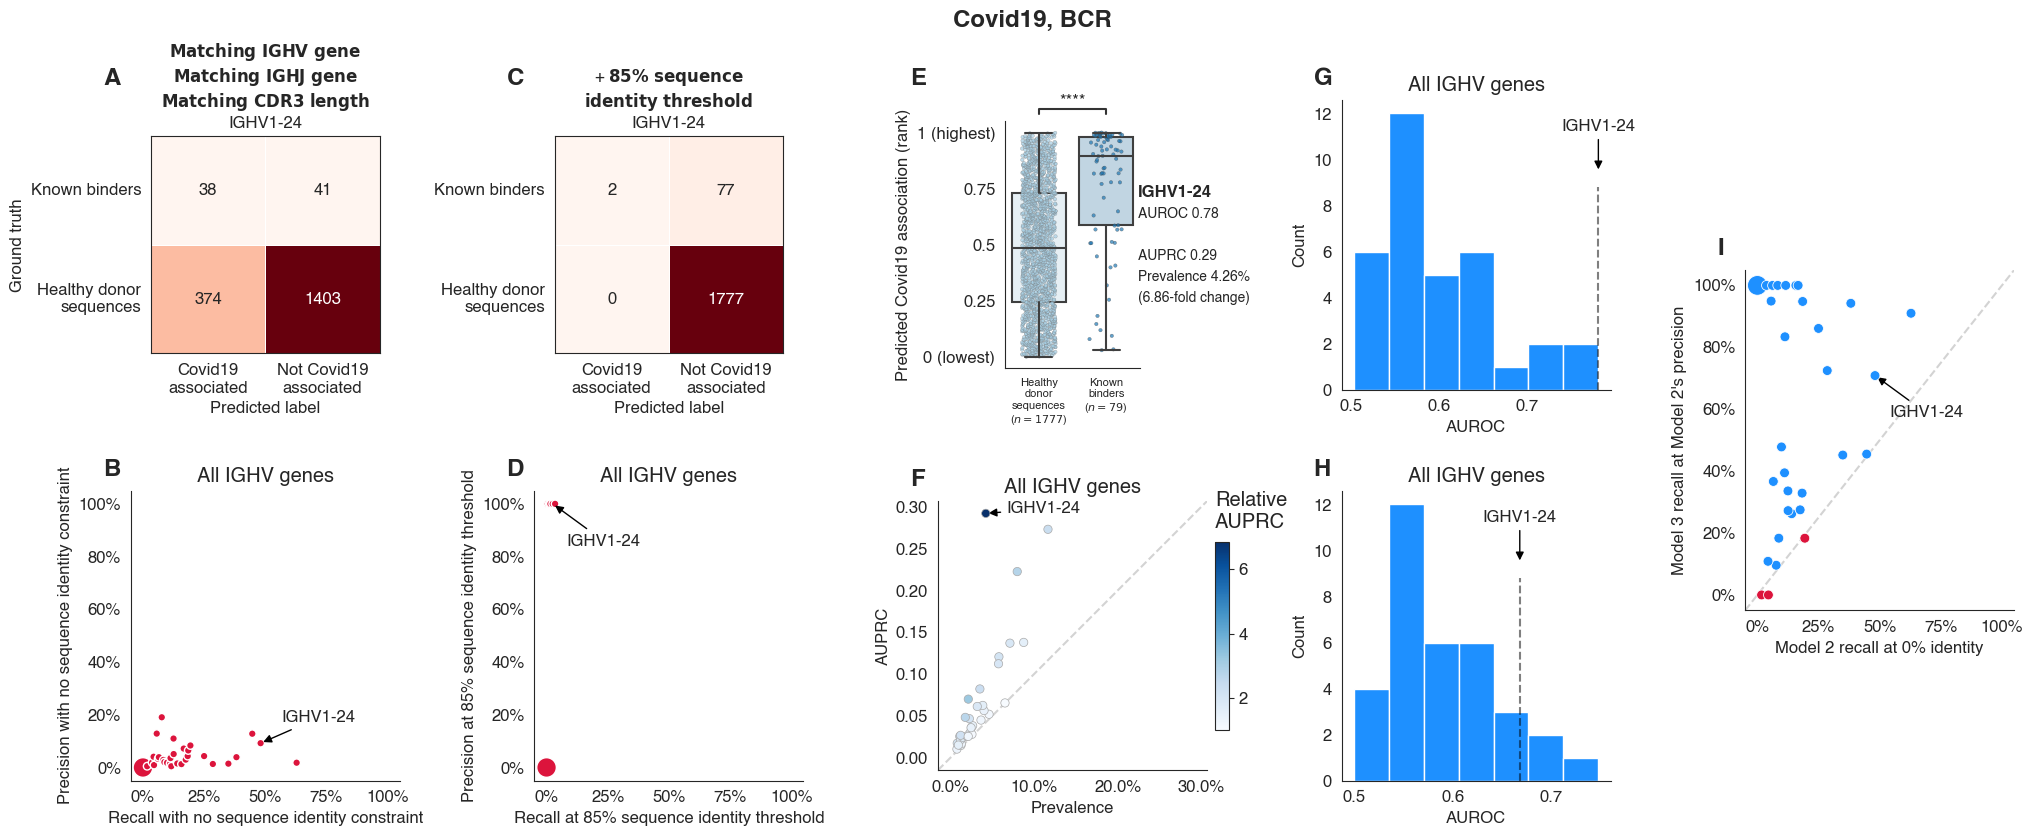

## GeneLocus.BCR, Influenza

Prevalence: 0.62%
Percent of known binders with infinite distance by model 2: 68.10%

Model 2 PPV (at 0.85 similarity decision threshold):  count    12.000000
mean      0.104167
std       0.291125
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       1.000000
Name: ppv_model2_stricter, dtype: float64

Model 2 PPV (at 0% similarity decision threshold): count    12.000000
mean      0.007281
std       0.007143
min       0.001546
25%       0.003290
50%       0.005130
75%       0.006733
max       0.026459
Name: ppv_model2, dtype: float64

Model 2 sensitivity (at 0% similarity decision threshold): count    12.000000
mean      0.308025
std       0.127333
min       0.095238
25%       0.229199
50%       0.291791
75%       0.371552
max       0.515152
Name: sensitivity_model2, dtype: float64

Model 2 sensitivity (at 0.85 similarity decision threshold): count    12.000000
mean      0.001415
std       0.003506
min       0.000000
25%       0.000000
50%       0.000000


,v_gene,auc_model3
19,IGHV1-46,0.650611
20,IGHV1-69,0.610191
8,IGHV4-39,0.605911
5,IGHV3-30,0.604124
12,IGHV3-21,0.599411
23,IGHV3-48,0.556433
17,IGHV1-2,0.550810
0,IGHV3-23,0.521225
24,IGHV1-18,0.499408
16,IGHV3-30-3,0.466883


Model 3 AUC for sequences skipped by model 2: count    12.000000
mean      0.541594
std       0.087968
min       0.418141
25%       0.480286
50%       0.557443
75%       0.591452
max       0.705580
Name: auc_model3_model2missing, dtype: float64

Top model 3 AUCs for sequences skipped by model 2:


,v_gene,auc_model3_model2missing
19,IGHV1-46,0.705580
12,IGHV3-21,0.618087
20,IGHV1-69,0.595304
8,IGHV4-39,0.590168
23,IGHV3-48,0.587726
5,IGHV3-30,0.570153
17,IGHV1-2,0.544734
16,IGHV3-30-3,0.519329
0,IGHV3-23,0.496065
10,IGHV4-59,0.432952


Fold change of model 3 AUPRC over prevalence: count    12.000000
mean      1.950731
std       0.995961
min       0.936976
25%       1.144933
50%       1.642178
75%       2.694017
max       3.991901
Name: auprc_model3_normalized, dtype: float64

Top model 3 AUPRC fold changes:


,v_gene,auprc_model3_normalized
8,IGHV4-39,3.991901
24,IGHV1-18,2.984268
19,IGHV1-46,2.828339
23,IGHV3-48,2.649243
20,IGHV1-69,2.296680
5,IGHV3-30,1.971198
12,IGHV3-21,1.313158
10,IGHV4-59,1.190738
17,IGHV1-2,1.145681
0,IGHV3-23,1.142687


Fold change of model 3 AUPRC over prevalence for sequences skipped by model 2: count    12.000000
mean      1.775434
std       1.064916
min       0.858311
25%       1.105001
50%       1.342157
75%       2.172588
max       4.648238
Name: auprc_model3_model2missing_normalized, dtype: float64

Top model 3 AUPRC fold changes for sequences skipped by model 2:


,v_gene,auprc_model3_model2missing_normalized
8,IGHV4-39,4.648238
5,IGHV3-30,2.414827
23,IGHV3-48,2.232756
20,IGHV1-69,2.152532
19,IGHV1-46,2.098647
12,IGHV3-21,1.387416
10,IGHV4-59,1.296898
17,IGHV1-2,1.161738
0,IGHV3-23,1.112753
16,IGHV3-30-3,1.081744


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 205.64it/s]


Permutation tests with 1000 permutations: P-value: 0.008. True normalized AUPRC: 2.296680364295771
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Known binders vs. Healthy donor sequences: Custom statistical test, P_val:8.000e-03


{"message": "/tmp/ipykernel_620282/919053723.py:844: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.\n  plt.tight_layout()\n", "time": "2024-03-23T22:34:59.935934"}


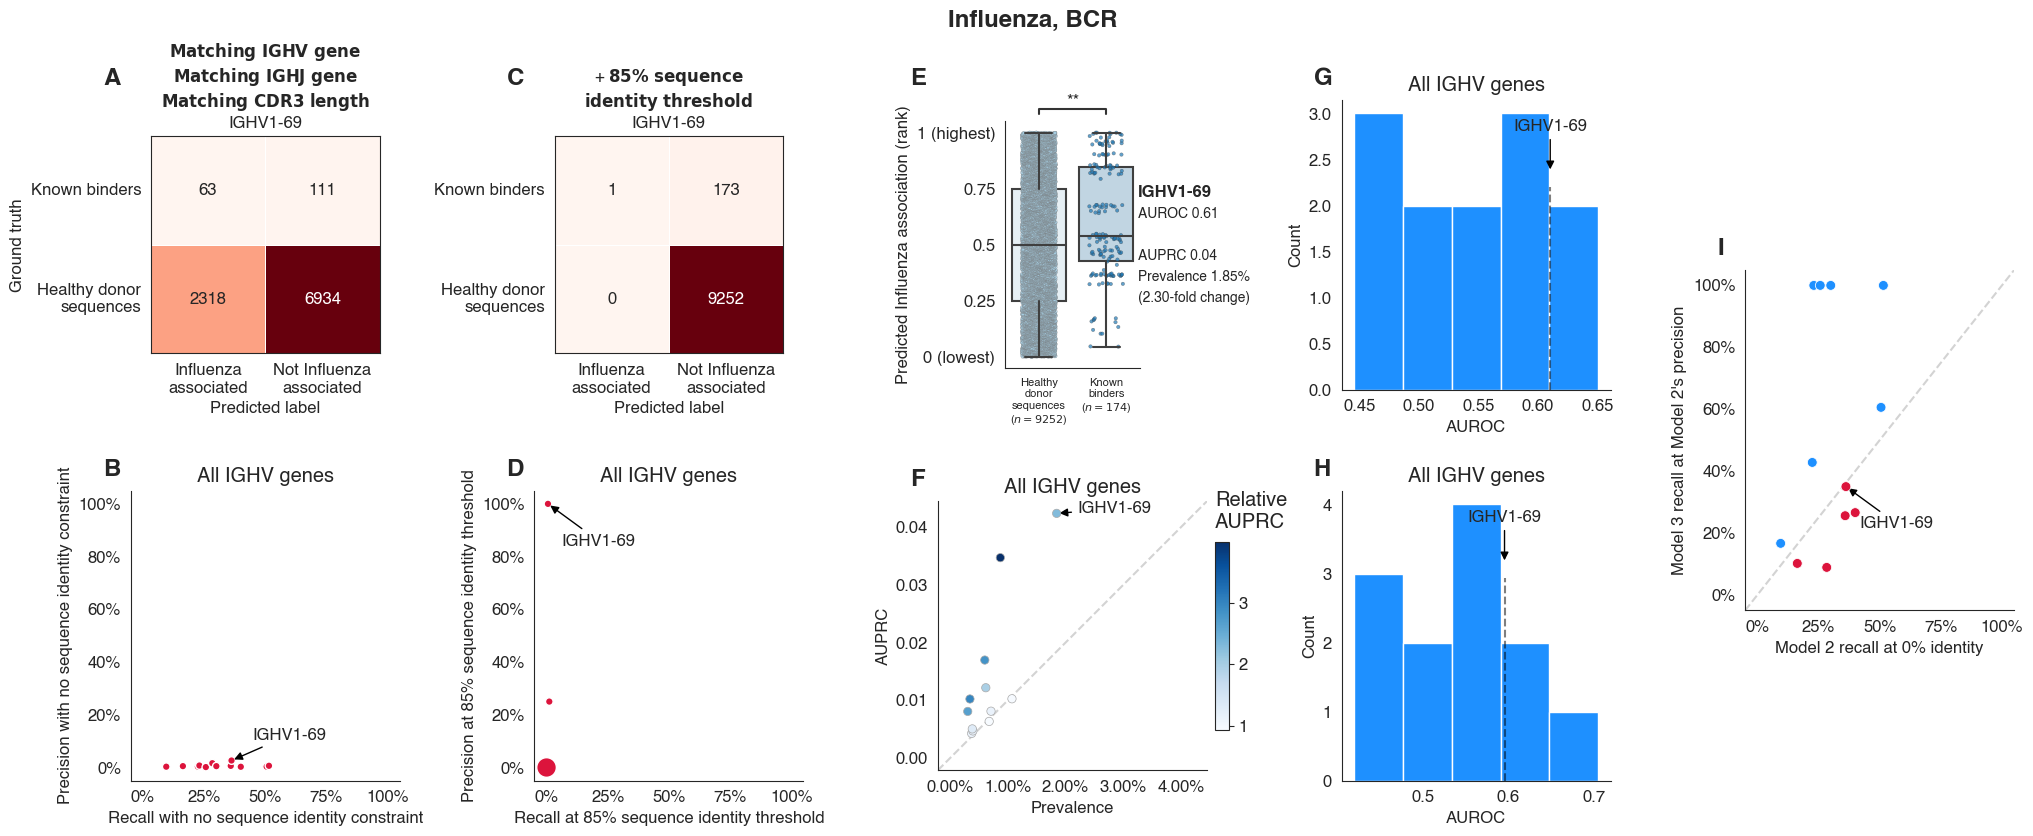

## GeneLocus.TCR, Covid19

Prevalence: 0.75%
Percent of known binders with infinite distance by model 2: 99.69%

Model 2 PPV (at 0.9 similarity decision threshold):  count    28.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: ppv_model2_stricter, dtype: float64

Model 2 PPV (at 0% similarity decision threshold): count    28.000000
mean      0.001055
std       0.003192
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       0.014742
Name: ppv_model2, dtype: float64

Model 2 sensitivity (at 0% similarity decision threshold): count    28.000000
mean      0.001781
std       0.007489
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       0.039374
Name: sensitivity_model2, dtype: float64

Model 2 sensitivity (at 0.9 similarity decision threshold): count    28.0
mean      0.0
std       0.0
min       0.0
25%       0.0
50%       0.0
75%       0.0
max       0.0
Name: sensitivity_model2_stricter, dtype: fl

,v_gene,auc_model3
14,TRBV10-3,0.568836
22,TRBV6-1,0.559645
4,TRBV6-6,0.548250
20,TRBV20-1,0.527845
12,TRBV9,0.525826
3,TRBV7-8,0.517843
21,TRBV7-6,0.511700
2,TRBV4-1,0.509346
5,TRBV30,0.507863
8,TRBV24-1,0.507769


Model 3 AUC for sequences skipped by model 2: count    28.000000
mean      0.499595
std       0.028397
min       0.456189
25%       0.477945
50%       0.498754
75%       0.509934
max       0.568836
Name: auc_model3_model2missing, dtype: float64

Top model 3 AUCs for sequences skipped by model 2:


,v_gene,auc_model3_model2missing
14,TRBV10-3,0.568836
22,TRBV6-1,0.559645
4,TRBV6-6,0.548250
20,TRBV20-1,0.527845
12,TRBV9,0.525826
3,TRBV7-8,0.517843
21,TRBV7-6,0.511700
2,TRBV4-1,0.509346
5,TRBV30,0.507863
8,TRBV24-1,0.507769


Fold change of model 3 AUPRC over prevalence: count    28.000000
mean      1.046149
std       0.121236
min       0.881233
25%       0.965404
50%       1.017631
75%       1.084422
max       1.359739
Name: auprc_model3_normalized, dtype: float64

Top model 3 AUPRC fold changes:


,v_gene,auprc_model3_normalized
22,TRBV6-1,1.359739
4,TRBV6-6,1.324423
14,TRBV10-3,1.310944
20,TRBV20-1,1.194597
5,TRBV30,1.115210
8,TRBV24-1,1.112290
12,TRBV9,1.084680
3,TRBV7-8,1.084336
21,TRBV7-6,1.083928
15,TRBV11-2,1.037959


Fold change of model 3 AUPRC over prevalence for sequences skipped by model 2: count    28.000000
mean      1.045799
std       0.121457
min       0.881233
25%       0.965404
50%       1.016607
75%       1.084422
max       1.359739
Name: auprc_model3_model2missing_normalized, dtype: float64

Top model 3 AUPRC fold changes for sequences skipped by model 2:


,v_gene,auprc_model3_model2missing_normalized
22,TRBV6-1,1.359739
4,TRBV6-6,1.324423
14,TRBV10-3,1.310944
20,TRBV20-1,1.194597
5,TRBV30,1.115210
8,TRBV24-1,1.112290
12,TRBV9,1.084680
3,TRBV7-8,1.084336
21,TRBV7-6,1.083928
15,TRBV11-2,1.037959


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.91it/s]


Permutation tests with 1000 permutations: P-value: 0.002. True normalized AUPRC: 1.310944226069743
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Known binders vs. Healthy donor sequences: Custom statistical test, P_val:2.000e-03


{"message": "/tmp/ipykernel_620282/919053723.py:844: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.\n  plt.tight_layout()\n", "time": "2024-03-23T22:35:33.650773"}


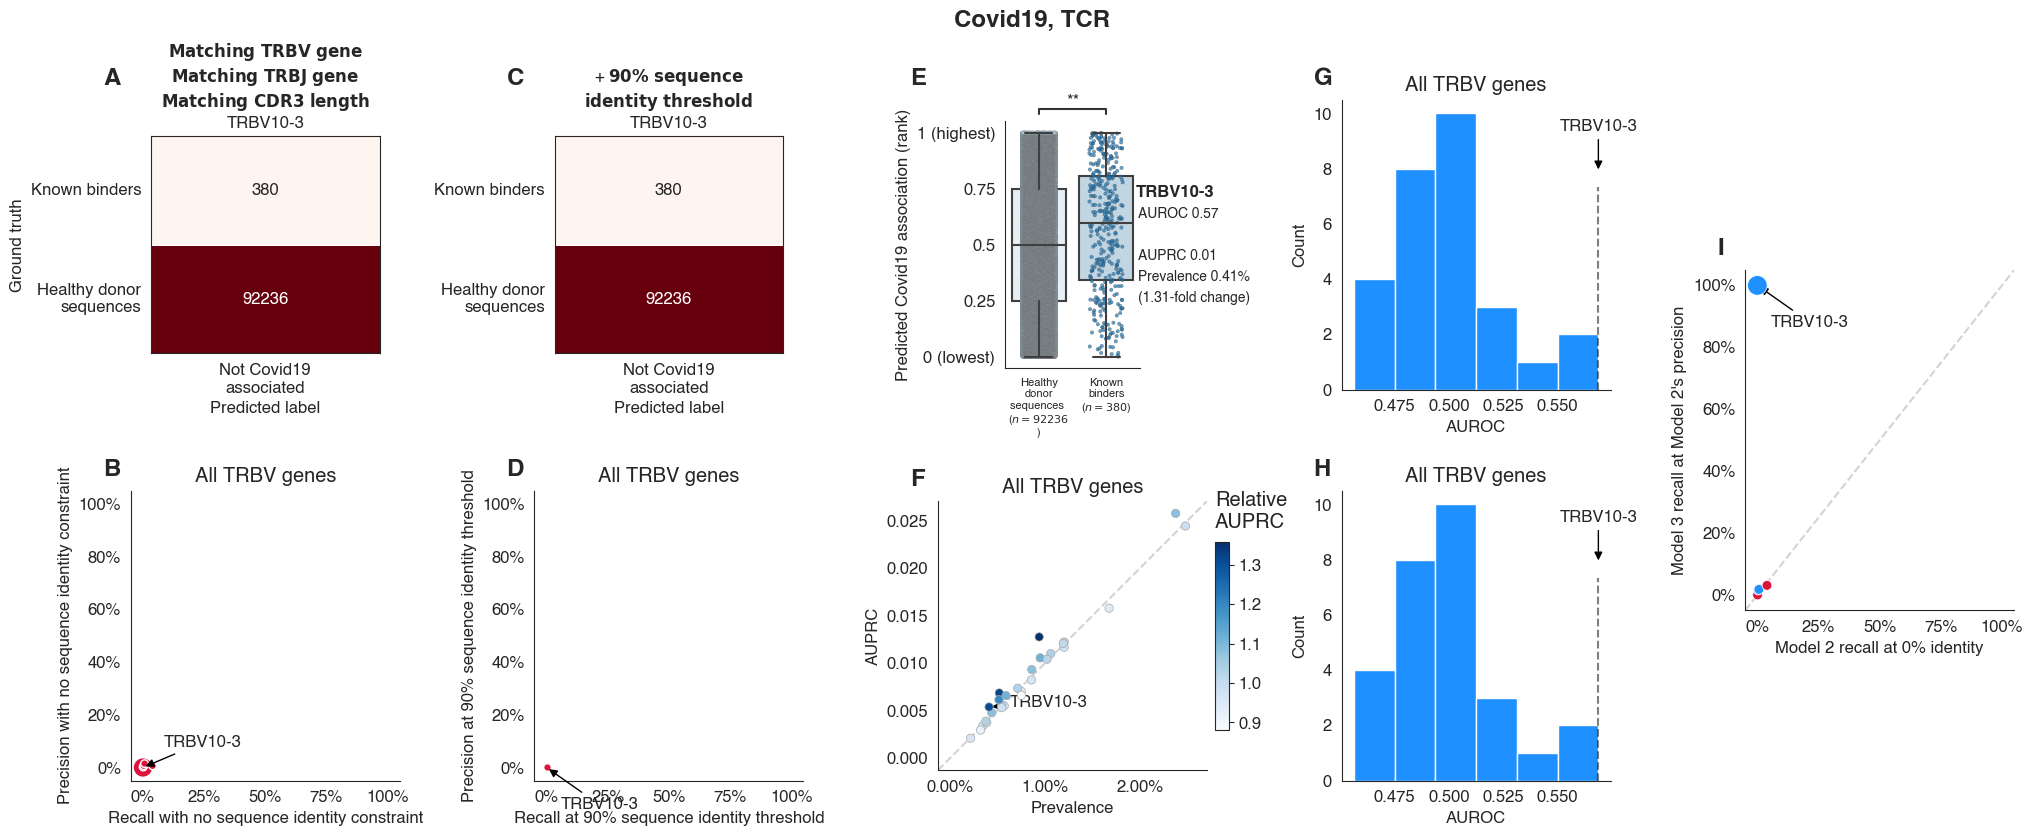

In [10]:
# color3 = sns.color_palette()[0]
color3 = "dodgerblue"

# color2 = sns.color_palette("Set2")[1]
# color2 = "gray"
color2 = "crimson"


def _shrink_a_subplot(ax, width="85%", height="85%"):
    # Make this subplot smaller
    # [x, y, width, height] in fractions of the subplot size
    # new_ax = ax.inset_axes([0.1, 0.1, 0.8, 0.8])

    new_ax = inset_axes(
        parent_axes=ax,
        # width and height relative to parent bbox (ax)
        width=width,
        height=height,
        # Center horizontal-align and center vertical-align the legend relative to this anchor point:
        bbox_to_anchor=(0, 0, 1, 1),
        loc="center",
        bbox_transform=ax.transAxes,
        borderpad=0,
    )
    ax.axis("off")  # Hide original subplot's axes
    return new_ax


for (gene_locus, disease), (
    v_gene_results_filtered,
    (v_gene_to_highlight, combined_data_for_that_v_gene),
) in saved_results.items():
    display(Markdown(f"## {gene_locus}, {disease}"))
    stricter_threshold = (
        config.sequence_identity_thresholds.assign_test_sequences_to_clusters[
            gene_locus
        ]
    )

    gene_type = "IGHV" if gene_locus == GeneLocus.BCR else "TRBV"
    gene_type_j = "IGHJ" if gene_locus == GeneLocus.BCR else "TRBJ"
    v_gene_results_for_this_gene = v_gene_results_filtered.set_index("v_gene").loc[
        v_gene_to_highlight
    ]

    model2_confusion_matrix = genetools.stats.make_confusion_matrix(
        y_true=combined_data_for_that_v_gene["source"],
        y_pred=(combined_data_for_that_v_gene["centroid_proximity_score"] > 0).map(
            {True: known_binders_label, False: healthy_sequences_label}
        ),
        true_label="Ground truth",
        pred_label="Predicted label",
        label_order=[known_binders_label, healthy_sequences_label],
    ).rename(
        columns={
            known_binders_label: f"{disease} associated",
            healthy_sequences_label: f"Not {disease} associated",
        }
    )
    model2_confusion_matrix_stricter = genetools.stats.make_confusion_matrix(
        y_true=combined_data_for_that_v_gene["source"],
        y_pred=(
            combined_data_for_that_v_gene["centroid_proximity_score"]
            >= stricter_threshold
        ).map({True: known_binders_label, False: healthy_sequences_label}),
        true_label="Ground truth",
        pred_label="Predicted label",
        label_order=[known_binders_label, healthy_sequences_label],
    ).rename(
        columns={
            known_binders_label: f"{disease} associated",
            healthy_sequences_label: f"Not {disease} associated",
        }
    )

    # Prevalence
    print(
        f"Prevalence: {v_gene_results_filtered['n_known_binders'].sum() / (v_gene_results_filtered['n_known_binders'].sum() + v_gene_results_filtered['n_healthy'].sum()):0.2%}"
    )
    # Percent of known binders with 0 i.e. infinite distance scores by Model 2
    print(
        f"Percent of known binders with infinite distance by model 2: {(v_gene_results_filtered['n_known_binders'] - v_gene_results_filtered['n_known_binders_nonzero']).sum() / v_gene_results_filtered['n_known_binders'].sum():0.2%}"
    )
    print()

    print(
        f"Model 2 PPV (at {stricter_threshold} similarity decision threshold): ",
        v_gene_results_filtered["ppv_model2_stricter"].describe(),
    )
    print()

    print(
        "Model 2 PPV (at 0% similarity decision threshold):",
        v_gene_results_filtered["ppv_model2"].describe(),
    )
    print()

    print(
        "Model 2 sensitivity (at 0% similarity decision threshold):",
        v_gene_results_filtered["sensitivity_model2"].describe(),
    )
    print()

    print(
        f"Model 2 sensitivity (at {stricter_threshold} similarity decision threshold):",
        v_gene_results_filtered["sensitivity_model2_stricter"].describe(),
    )
    print()

    print(f"Model 2 PPVs (at {stricter_threshold} similarity decision threshold):")
    print(
        v_gene_results_filtered["ppv_model2_stricter"].value_counts(),
    )
    print()

    print(
        f"Model 2 PPVs (at {stricter_threshold} similarity decision threshold): V genes with PPV=1 are: ",
        v_gene_results_filtered[v_gene_results_filtered["ppv_model2_stricter"] == 1][
            "v_gene"
        ]
        .sort_values()
        .tolist(),
    )
    print()

    print("Model 3 AUC:", v_gene_results_filtered["auc_model3"].describe())
    print()

    print("Top model 3 AUCs:")
    display(
        v_gene_results_filtered.sort_values("auc_model3", ascending=False)[
            ["v_gene", "auc_model3"]
        ].head(n=10)
    )

    print(
        "Model 3 AUC for sequences skipped by model 2:",
        v_gene_results_filtered["auc_model3_model2missing"].describe(),
    )
    print()

    print("Top model 3 AUCs for sequences skipped by model 2:")
    display(
        v_gene_results_filtered.sort_values(
            "auc_model3_model2missing", ascending=False
        )[["v_gene", "auc_model3_model2missing"]].head(n=10)
    )

    print(
        "Fold change of model 3 AUPRC over prevalence:",
        v_gene_results_filtered["auprc_model3_normalized"].describe(),
    )
    print()

    print("Top model 3 AUPRC fold changes:")
    display(
        v_gene_results_filtered.sort_values("auprc_model3_normalized", ascending=False)[
            ["v_gene", "auprc_model3_normalized"]
        ].head(n=10)
    )

    print(
        "Fold change of model 3 AUPRC over prevalence for sequences skipped by model 2:",
        v_gene_results_filtered["auprc_model3_model2missing_normalized"].describe(),
    )
    print()

    print("Top model 3 AUPRC fold changes for sequences skipped by model 2:")
    display(
        v_gene_results_filtered.sort_values(
            "auprc_model3_model2missing_normalized", ascending=False
        )[["v_gene", "auprc_model3_model2missing_normalized"]].head(n=10)
    )

    ####

    n_panels = 5
    fig, axarr = plt.subplots(figsize=(4 * n_panels, 4 * 2), nrows=2, ncols=n_panels)

    #
    # Precision-recall values for model 2 at 0% similarity decision threshold

    ax = axarr[0, 0]
    ax = _shrink_a_subplot(ax, height="75%")

    _, ax = genetools.plots.plot_confusion_matrix(
        df=model2_confusion_matrix,
        ax=ax,
        cmap="Reds",
    )
    latex_space_character = r"\ "
    # ax.set_title(r"$\bf{0\%\ threshold}$" + f"\n{v_gene_to_highlight}")
    ax.set_title(
        "\n".join(
            [
                r"$\bf{"
                + latex_space_character.join(["Matching", gene_type, "gene"])
                + r"}$",
                r"$\bf{"
                + latex_space_character.join(["Matching", gene_type_j, "gene"])
                + r"}$",
                r"$\bf{"
                + latex_space_character.join(["Matching", "CDR3", "length"])
                + r"}$",
                v_gene_to_highlight,
            ]
        ),
        fontsize="medium",
    )

    ax = sns.scatterplot(
        data=v_gene_results_filtered.groupby(["sensitivity_model2", "ppv_model2"])
        .size()
        .reset_index(name="counts"),
        x="sensitivity_model2",
        y="ppv_model2",
        size="counts",
        # hue="counts",
        # palette='flare',
        edgecolors="lightgrey",
        linewidth=1,
        # alpha=0.9,
        legend=False,
        color=color2,
        sizes=(30, 200),
        ax=axarr[1, 0],
    )
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    sns.despine(ax=ax)
    ax.set_xlabel("Recall with no sequence identity constraint")
    ax.set_ylabel("Precision with no sequence identity constraint")
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
    ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
    ax.set_title(f"All {gene_type} genes")
    x, y = v_gene_results_for_this_gene[
        ["sensitivity_model2", "ppv_model2"]
    ].values.ravel()
    ax.annotate(
        v_gene_to_highlight,
        (x, y),
        xycoords="data",
        xytext=(15, 15),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>", color="black"),
    )

    #
    # Precision-recall values for model 2 at stricter similarity decision threshold

    ax = axarr[0, 1]
    ax = _shrink_a_subplot(ax, height="75%")

    _, ax = genetools.plots.plot_confusion_matrix(
        df=model2_confusion_matrix_stricter,
        ax=ax,
        cmap="Reds",
    )
    ax.set_ylabel(None)
    # ax.set_title(
    #     r"$\bf{"
    #     + f"{stricter_threshold:.0%}".replace("%", r"\%")
    #     + latex_space_character
    #     + r"threshold}$"
    #     + f"\n{v_gene_to_highlight}"
    # )
    ax.set_title(
        r"+ $\bf{"
        + f"{stricter_threshold:.0%}".replace("%", r"\%")
        + latex_space_character
        + "sequence"
        + r"}$"
        + "\n"
        + r"$\bf{"
        + latex_space_character.join(["identity", "threshold"])
        + r"}$"
        + f"\n{v_gene_to_highlight}",
        fontsize="medium",
    )

    ax = sns.scatterplot(
        data=v_gene_results_filtered.groupby(
            ["sensitivity_model2_stricter", "ppv_model2_stricter"]
        )
        .size()
        .reset_index(name="counts"),
        x="sensitivity_model2_stricter",
        y="ppv_model2_stricter",
        size="counts",
        # hue="counts",
        # palette='flare',
        edgecolors="#777",
        linewidth=1,
        # alpha=0.9,
        legend=False,
        color=color2,
        sizes=(30, 200),
        ax=axarr[1, 1],
    )
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    sns.despine(ax=ax)
    ax.set_xlabel(f"Recall at {stricter_threshold:.0%} sequence identity threshold")
    ax.set_ylabel(f"Precision at {stricter_threshold:.0%} sequence identity threshold")
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
    ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
    ax.set_title(f"All {gene_type} genes")
    x, y = v_gene_results_for_this_gene[
        ["sensitivity_model2_stricter", "ppv_model2_stricter"]
    ].values.ravel()
    ax.annotate(
        v_gene_to_highlight,
        (x, y),
        xycoords="data",
        xytext=(10, -30),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>", color="black"),
    )

    # Model 3 Rank plot for a single V gene
    mann_whitney_test_method = "asymptotic"
    axis_label = f"Predicted {disease} association (rank)"
    order = [healthy_sequences_label, known_binders_label]
    ax = axarr[0, 2]
    ax = _shrink_a_subplot(ax, width="50%")

    # rank_col = "model3_predicted_proba"
    # Generate a rank col
    rank_col = "rank"
    # Assign a rank (higher ranks are higher probabilities)
    combined_data_for_that_v_gene.sort_values(
        "model3_predicted_proba", ascending=True, inplace=True
    )
    combined_data_for_that_v_gene[rank_col] = genetools.stats.rank_normalize(
        combined_data_for_that_v_gene["model3_predicted_proba"]
    )
    # percentile normalize
    combined_data_for_that_v_gene[rank_col] = (
        combined_data_for_that_v_gene[rank_col] / combined_data_for_that_v_gene.shape[0]
    )

    sns.boxplot(
        data=combined_data_for_that_v_gene,
        x="source",
        y=rank_col,
        ax=ax,
        order=order,
        palette=sns.color_palette("Paired")[:2],
    )

    for patch in ax.patches:
        # Set boxplot alpha transparency: https://github.com/mwaskom/seaborn/issues/979#issuecomment-1144615001
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, 0.3))
    sns.stripplot(
        data=combined_data_for_that_v_gene,
        x="source",
        y=rank_col,
        order=order,
        hue="source",
        legend=None,
        linewidth=0.25,
        edgecolor="gray",
        palette=sns.color_palette("Paired")[:2],
        ax=ax,
        size=2.5,
        jitter=0.25,
        zorder=1,
        alpha=0.7,
    )

    # Annotate with statistical significance
    annot = Annotator(
        ax=ax,
        pairs=[order],
        data=combined_data_for_that_v_gene,
        x="source",
        y=rank_col,
        # This "order" is the reverse of the seaborn plotting order:
        # Specify pair order for the one-sided test that the the known binders have greater ranks than the healthy sequences.
        # (Make sure to be consistent with the scipy equivalent below about which is the "greater" and which is the "less" sample)
        order=list(reversed(order)),
    )
    # Old: standard Mann-Whitney
    # annot.configure(
    #     test="Mann-Whitney-gt", text_format="star", loc="outside", verbose=2
    # )
    # annot.apply_test(method=mann_whitney_test_method)
    # ax, test_results_for_annotator = annot.annotate()

    # Reproduce the test ourselves: Wilcoxon rank-sum test, one sided.
    ranks_known_binders = combined_data_for_that_v_gene[
        combined_data_for_that_v_gene["source"] == known_binders_label
    ][rank_col].values
    ranks_other = combined_data_for_that_v_gene[
        combined_data_for_that_v_gene["source"] == healthy_sequences_label
    ][rank_col].values

    # The Wilcoxon rank-sum test tests the null hypothesis that two sets of measurements are drawn from the same distribution.
    # The alternative hypothesis is that values in one sample are more likely to be greater than the values in the other sample.
    significance_test = scipy.stats.mannwhitneyu(
        ranks_known_binders,
        ranks_other,
        alternative="greater",
        method=mann_whitney_test_method,
    )
    # # Confirm StatResult matches against scipy's p-value and test statistic
    # (Disabling because we disabled standard Mann-Whitney plotting)
    # assert np.allclose(
    #     significance_test.pvalue, test_results_for_annotator[0].data.pvalue
    # )
    # assert np.allclose(
    #     significance_test.statistic, test_results_for_annotator[0].data.stat_value
    # )

    ###
    # Do our own custom permutation test, permuting the healthy/binder labels while keeping all sequences from the same healthy individual together

    def calculate_auprc_fold_change(df):
        """Calculate AUPRC and divide by prevalence (i.e. return AUPRC fold change)."""

        y_score = df["model3_predicted_proba"]
        y_true = df["label"]
        auprc = sklearn.metrics.average_precision_score(
            y_true=y_true,
            y_score=y_score,
        )

        prevalence = (
            y_true.value_counts(normalize=True).reindex([0, 1], fill_value=0).loc[1]
        )

        return auprc / prevalence, prevalence

    # Set up
    permuted_df = combined_data_for_that_v_gene.copy()
    permuted_df["label"] = permuted_df["source"].map(
        {healthy_sequences_label: 0, known_binders_label: 1}
    )

    # Before any permutations:
    # Calculate true AUPRC over baseline prevalence
    true_auprc_fold_change, true_prevalence = calculate_auprc_fold_change(permuted_df)
    # true_auprc_fold_change, true_prevalence

    ## Design the permutations

    # Total number of binder sequences
    num_binders = (
        permuted_df["label"].value_counts().reindex([0, 1], fill_value=0).loc[1]
    )

    # Approximate number of sequences each healthy donor contributes
    sequences_per_donor = (
        permuted_df[permuted_df["label"] == 0]
        .groupby("participant_label")
        .size()
        .median()
    )

    # Calculate the number of healthy donors needed to approximate the number of binders
    n_healthy_donors_needed = int(num_binders // sequences_per_donor)
    # If the number of binders is smaller than the sequences per donor, our computation would give n_healthy_donors_needed = 0
    # Achieving the target prevalence is hard!
    # We must at least shift one person around:
    n_healthy_donors_needed = max(n_healthy_donors_needed, 1)
    assert n_healthy_donors_needed >= 1  # sanity check

    def permute_in_place(permuted_scores: pd.DataFrame) -> pd.DataFrame:
        """
        Shuffle labels while respecting the patient clustering and prevalence.

        Shuffle the labels across the whole data, not separately/differently in each sequence group. By shuffling the labels consistently across sequence groups, we will maintain the integrity of each individual healthy donor's data.
        This means that if we label a particular donor's sequence as "binder" in one sequence group, it should consistently have the same label across all other sequence groups in that permutation.

        Considering the low prevalence of binders, we also need to ensure that the proportion of binders and healthy sequences remains roughly the same after the shuffle to respect the original distribution.
        (But we remedy this also by using AUPRC fold change, normalized by baseline prevalence)
        """
        # We have already scored and combined the known binders and healthy data.
        # Now we just permute the label column inplace, so it can be passed straight to scoring functions.

        # The sequences from healthy donors are the ones with participant_label set.
        mask_healthy_donor_sequences = permuted_scores["participant_label"].notna()
        mask_known_binder_sequences = ~mask_healthy_donor_sequences

        # Before permuting, reset labels back to original: 1 is binder, 0 is healthy
        permuted_scores["label"] = mask_known_binder_sequences.astype(int)

        # Randomly select healthy donors to reassign as binders
        healthy_donor_participant_labels = (
            permuted_scores["participant_label"].dropna().unique()
        )
        selected_healthy_donors = np.random.choice(
            healthy_donor_participant_labels,
            n_healthy_donors_needed,
            replace=False,
        )

        # Start swapping labels:
        # Turn selected healthy sequences into binders (set label to 1)
        mask_for_selected_healthy_donor_sequences_that_will_become_binders = (
            permuted_scores["participant_label"].isin(selected_healthy_donors)
        )
        permuted_scores.loc[
            mask_for_selected_healthy_donor_sequences_that_will_become_binders,
            "label",
        ] = 1

        # Swap more labels:
        # Since binder sequences don't need to maintain structure (they don't originate from participant_labels), simply relabel an equivalent number as healthy.
        # Select random binder sequences to change to healthy:
        # n_binders_to_change = len(selected_healthy_donors) * sequences_per_donor
        n_binders_to_change = (
            mask_for_selected_healthy_donor_sequences_that_will_become_binders.sum()
        )
        known_binder_sequence_indices = permuted_scores[
            mask_known_binder_sequences
        ].index
        binders_to_healthy_indices = np.random.choice(
            known_binder_sequence_indices,
            min(n_binders_to_change, known_binder_sequence_indices.shape[0]),
            replace=False,
        )
        # Change to healthy
        permuted_scores.loc[binders_to_healthy_indices, "label"] = 0

        # Sanity check:
        # Check that each healthy donor has consistent label for all their sequences
        assert (
            permuted_scores.groupby("participant_label")["label"].nunique() == 1
        ).all(), "Some healthy participants have multiple labels, which should not happen. Each healthy donor should have consistent label for all their sequences"

        # If we add "fold_label" column, we could review label swapping:
        # permuted_scores.groupby(['fold_label', 'label']).size()
        return permuted_scores

    # Configure number of permutations
    n_permutations = 1000
    normalized_auprcs = []
    prevalences = []

    # Run the permutations
    for _ in tqdm(range(n_permutations)):
        # Permute labels, keeping all sequences from the same healthy donor together
        permuted_df = permute_in_place(
            permuted_scores=permuted_df,
        )

        # Calculate AUPRC for the permuted dataset
        # Known binder prevalence will be different, so we use normalized AUPRC
        auprc_fold_change_permuted, prevalence_permuted = calculate_auprc_fold_change(
            permuted_df
        )
        normalized_auprcs.append(auprc_fold_change_permuted)
        prevalences.append(prevalence_permuted)

    assert len(normalized_auprcs) == len(prevalences) == n_permutations
    # Calculate p-value: proportion of permutations with AUPRC >= true AUPRC
    # This is a one-sided test. Null hypothesis is that the scores for known binders are not higher than those for healthy sequences.
    p_value = np.mean([auprc >= true_auprc_fold_change for auprc in normalized_auprcs])

    permutation_test_result = f"Permutation tests with {n_permutations} permutations: P-value: {p_value}. True normalized AUPRC: {true_auprc_fold_change}"
    print(permutation_test_result)

    # fig, ax = plt.subplots()
    # ax.hist(normalized_auprcs)
    # ax.axvline(true_auprc_fold_change)

    # fig, ax = plt.subplots()
    # ax.hist(prevalences)
    # ax.axvline(true_prevalence)

    # Plot our own p-value on the boxplot
    annot.configure(test=None, text_format="star", loc="outside", verbose=2)
    annot.set_pvalues([p_value])
    ax, test_results_for_annotator = annot.annotate()

    ####

    # Finish plot
    ax.set_ylabel(axis_label)
    ax.set_xlabel(None)
    ax.set_xticklabels(
        genetools.plots.add_sample_size_to_labels(
            ax.get_xticklabels(), combined_data_for_that_v_gene, "source"
        ),
        fontsize=8,
    )
    genetools.plots.wrap_tick_labels(ax, wrap_amount=10)
    ax.set_ylim(-0.05, 1.05)
    # higher rank means higher confidence
    ax.set_yticks(
        ticks=[0.0, 0.25, 0.5, 0.75, 1.0],
        labels=[
            "0 (lowest)",
            0.25,
            0.50,
            0.75,
            "1 (highest)",
        ],
    )

    # ax.set_title(v_gene_to_highlight)

    text_entries = [
        f"AUROC {v_gene_results_for_this_gene['auc_model3']:0.2f}",
        "",
        f"AUPRC {v_gene_results_for_this_gene['auprc_model3']:0.2f}",
        f"Prevalence {v_gene_results_for_this_gene['prevalence']:0.2%}",
        f"({v_gene_results_for_this_gene['auprc_model3_normalized']:0.2f}-fold change)",
    ]
    # Adjust the xlim to make room for text
    # ax.set_xlim(ax.get_xlim()[0] - 0.5, ax.get_xlim()[1] + 0.5)
    # ax.text(
    #     0.9,
    #     0.1,
    #     "\n".join(
    #         text_entries
    #     ),
    #     horizontalalignment="right",
    #     verticalalignment="bottom",
    #     transform=ax.transAxes,
    #     fontsize=10,
    #     zorder=20,
    #     # weight="bold",
    #     style="italic",
    # )

    leg = ax.legend(
        handles=[mpatches.Patch(color="none", label=txt) for txt in text_entries],
        # loc="upper left",
        # bbox_to_anchor=(0.5, 0.5),
        frameon=False,
        # Left horizontal-align and center vertical-align the legend relative to this anchor point:
        bbox_to_anchor=(0.65, 0, 1, 1),
        loc="center left",  # loc='lower left',
        bbox_transform=ax.transAxes,
        borderpad=0,
        title=v_gene_to_highlight,
        fontsize="small"
        # title_fontproperties={"weight": "bold", "size": "medium"} # ??
    )
    # set legend title to bold - workaround for title_fontproperties missing from old matplotlib versions
    leg.set_title(title=v_gene_to_highlight, prop={"weight": "bold", "size": "medium"})
    # align legend title left
    # leg._legend_box.align = "left"

    sns.despine(ax=ax)

    ##########

    # AUPRC
    ax = axarr[1, 2]

    scatter = ax.scatter(
        x=v_gene_results_filtered["prevalence"],
        y=v_gene_results_filtered["auprc_model3"],
        zorder=10,
        c=v_gene_results_filtered["auprc_model3_normalized"],
        # cmap="flare",
        cmap="Blues",
        # Add outlines to the scatter points:
        edgecolors="darkgrey",
        linewidths=0.5,
    )

    # https://stackoverflow.com/a/39938019/130164
    # divider = make_axes_locatable(ax)
    # cbar_ax = divider.append_axes('right', size='5%', pad=0.05)

    # Use this incantation instead to keep ax the same height as other axes, even though this one is burdened with a colorbar:
    cbar_ax = inset_axes(
        parent_axes=ax,
        # width and height relative to parent bbox (ax)
        width="5%",
        height="70%",  #
        # Left horizontal-align and center vertical-align the legend relative to this anchor point:
        bbox_to_anchor=(1.03, 0, 1, 1),
        loc="center left",  # loc='lower left',
        bbox_transform=ax.transAxes,
        borderpad=0,
    )

    cbar = fig.colorbar(
        scatter,
        cax=cbar_ax,  # orientation='vertical'
        # # https://stackoverflow.com/a/26720422/130164
        # ax=ax,
        # fraction=0.046,
        # pad=0.04,
    )
    # cbar.set_label(
    #     "Fold change",
    #     rotation=90,
    #     # size="medium",
    #     # weight="bold",
    #     # horizontalalignment="left",
    #     # verticalalignment="center",
    # )
    cbar_ax.set_title(
        "Relative\nAUPRC",
        loc="left",
        pad=10,  # fontweight="bold"
    )
    ax.axline((0, 0), slope=1, linestyle="dashed", color="lightgrey", zorder=1)
    ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
    ax.set_aspect("equal", "box")
    min_amount = min(ax.get_ylim()[0], ax.get_xlim()[0])
    max_amount = max(ax.get_ylim()[1], ax.get_xlim()[1])
    ax.set_ylim(min_amount, max_amount)
    ax.set_xlim(min_amount, max_amount)
    ax.set_xlabel("Prevalence")  # , fontsize=10)
    ax.set_ylabel("AUPRC")  # ,  fontsize=10)
    ax.set_title(f"All {gene_type} genes")
    sns.despine(ax=ax)
    x, y = v_gene_results_for_this_gene[["prevalence", "auprc_model3"]].values.ravel()
    ax.annotate(
        v_gene_to_highlight,
        (x, y),
        xycoords="data",
        xytext=(15, 0),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>", color="black"),
    )

    # AUC
    ax = axarr[0, 3]
    sns.histplot(
        data=v_gene_results_filtered, x="auc_model3", color=color3, alpha=1, ax=ax
    )  # , bins=10)
    ax.set_xlabel("AUROC")
    ax.set_title(f"All {gene_type} genes")
    sns.despine(ax=ax)
    x = v_gene_results_for_this_gene["auc_model3"]
    ax.axvline(x, ymin=0, ymax=0.7, linestyle="dashed", color="k", alpha=0.5, zorder=5)
    ax.annotate(
        v_gene_to_highlight,
        (x, ax.get_ylim()[1] * 0.75),
        xycoords="data",
        xytext=(0, 30),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>", color="black"),
        horizontalalignment="center",
    )

    # AUC for skipped sequences
    ax = axarr[1, 3]
    sns.histplot(
        data=v_gene_results_filtered,
        x="auc_model3_model2missing",
        color=color3,
        alpha=1,
        ax=ax,
    )  # , bins=10)
    ax.set_xlabel("AUROC")  # , fontsize=10)
    ax.set_title(f"All {gene_type} genes")
    sns.despine(ax=ax)
    x = v_gene_results_for_this_gene["auc_model3_model2missing"]
    ax.axvline(x, ymin=0, ymax=0.7, linestyle="dashed", color="k", alpha=0.5, zorder=5)
    ax.annotate(
        v_gene_to_highlight,
        (x, ax.get_ylim()[1] * 0.75),
        xycoords="data",
        xytext=(0, 30),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>", color="black"),
        horizontalalignment="center",
        zorder=10,
    )

    # Comparison
    ax = axarr[0, 4]

    # Remove unused last panel:
    # axarr[1, 4].remove()

    # Instead, combine with the space available for the unused last panel:
    # see https://matplotlib.org/stable/gallery/subplots_axes_and_figures/gridspec_and_subplots.html
    gs = axarr[0, 4].get_gridspec()
    axarr[0, 4].remove()
    axarr[1, 4].remove()
    ax = fig.add_subplot(gs[0:, 4])
    # now make an inner subplot that is centered in the available space
    big_ax = ax
    ax = _shrink_a_subplot(big_ax, width="100%", height="50%")
    # Put the new ax back in axarr, so we can label the panels later
    axarr[0, 4] = ax

    ax = sns.scatterplot(
        data=v_gene_results_filtered.assign(
            model3better=v_gene_results_filtered["model3_recall_at_desired_precision"]
            >= v_gene_results_filtered["sensitivity_model2"]
        )
        .groupby(
            ["model3_recall_at_desired_precision", "sensitivity_model2", "model3better"]
        )
        .size()
        .reset_index(name="counts"),
        x="sensitivity_model2",
        y="model3_recall_at_desired_precision",
        size="counts",
        hue="model3better",
        legend=False,
        palette={True: color3, False: color2},
        sizes=(50, 200),
        zorder=20,
        ax=ax,
    )
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.axline((0, 0), slope=1, linestyle="dashed", color="lightgrey", zorder=1)
    ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
    ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
    ax.set_xlabel("Model 2 recall at 0% identity")
    ax.set_ylabel("Model 3 recall at Model 2's precision")
    sns.despine(ax=ax)
    x, y = v_gene_results_for_this_gene[
        ["sensitivity_model2", "model3_recall_at_desired_precision"]
    ].values.ravel()
    ax.annotate(
        v_gene_to_highlight,
        (x, y),
        xycoords="data",
        xytext=(10, -30),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="-|>", color="black"),
    )

    # Label subplot panels for figure
    for letter_label, ax in zip(string.ascii_uppercase, axarr.T.ravel()):
        # https://matplotlib.org/3.5.1/gallery/text_labels_and_annotations/label_subplots.html
        # label physical distance to the left and up:
        trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)
        ax.text(
            0.0,
            1.0,
            letter_label,
            transform=ax.transAxes + trans,
            fontsize="x-large",
            va="bottom",
            fontweight="bold",
        )

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5)

    # # Add separators
    # for separator_after_n_panels in [2, 4]:
    #     separator_x = separator_after_n_panels / n_panels
    #     line = plt.Line2D(
    #         (separator_x, separator_x), (0.15, 0.9), color="darkgrey", linewidth=2
    #     )
    #     fig.add_artist(line)

    fig.suptitle(
        f"{disease}, {gene_locus.name}", y=1.05, fontweight="bold", fontsize="x-large"
    )

    # Save values and plot
    output_dir = config.paths.model_interpretations_output_dir / gene_locus.name
    output_dir.mkdir(parents=True, exist_ok=True)
    genetools.plots.savefig(
        fig, output_dir / f"known_binders.model2_vs_3.{slugify(disease)}.png", dpi=300
    )
    v_gene_results_filtered.to_csv(
        output_dir / f"known_binders.model2_vs_3.{slugify(disease)}.tsv",
        sep="\t",
        index=None,
    )

    # Also export the permutation tests
    if test_results_for_annotator is not None and len(test_results_for_annotator) > 0:
        (
            output_dir
            / f"known_binders.model2_vs_3.{slugify(disease)}.test_results.what_was_plotted.txt"
        ).write_text(
            v_gene_to_highlight
            + "\n"
            + test_results_for_annotator[0].data.formatted_output
            + "\n"
        )
    (
        output_dir
        / f"known_binders.model2_vs_3.{slugify(disease)}.test_results.default_mann_whitney.txt"
    ).write_text(
        "\n".join(
            [
                v_gene_to_highlight,
                "Mann-Whitney-Wilcoxon test greater",
                f"p-value: {significance_test.pvalue}",
                f"U-statistic: {significance_test.statistic}",
                "",
            ]
        )
    )
    (
        output_dir
        / f"known_binders.model2_vs_3.{slugify(disease)}.test_results.custom_permutation_test.txt"
    ).write_text(v_gene_to_highlight + "\n" + permutation_test_result + "\n")

    display(fig)
    plt.close(fig)